In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Latent matrix from metadata

In [14]:
filename = '../data/2019_oct_sort_1000.csv'

In [15]:
!pwd

/home/cjergen/code/sailormoonvicky/eCommerce/notebooks


In [17]:
import random
p = 1  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df.shape

(1000, 9)

In [18]:
df.shape

(1000, 9)

In [19]:
df.category_code.nunique()

57

In [20]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [21]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-18 10:54:45 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
1,2019-10-18 10:55:20 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
2,2019-10-31 06:25:30 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.46,513782162,00000056-a206-40dd-b174-a072550fa38c
3,2019-10-31 06:25:52 UTC,view,5100816,2053013553375346967,NaN,xiaomi,29.60,513782162,00000056-a206-40dd-b174-a072550fa38c
4,2019-10-31 06:23:12 UTC,view,1005115,2053013555631882655,electronics.smartphone,apple,955.84,513782162,00000056-a206-40dd-b174-a072550fa38c


In [22]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [23]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/tmp/ipykernel_8577/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [24]:
X_preprocessed.shape

(445, 8)

## Pricing criterion

In [25]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [26]:
X_merged = pricing_criterion(X_preprocessed)

In [27]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [28]:
X_meta = metadata(X_merged)
X_meta.nunique()

event_type          3
product_id        310
category_id        61
category_code      50
brand              98
price             364
user_id           186
user_session      186
25%                50
75%                50
price_category      3
metadata          171
dtype: int64

In [29]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [30]:
print(X_meta.shape)
X_meta.head()

(445, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
49800017,view,49800017,2126679654801604876,accessories bag,ritmix,12.32,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,low,accessories bag ritmix low
49800020,view,49800020,2126679654801604876,accessories bag,ritmix,15.43,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,medium,accessories bag ritmix medium
28401080,view,28401080,2053013566209917945,accessories bag,respect,66.67,516007189,000037a4-c043-4113-9b53-7bbb5d7c2bfe,13.8750,41.0500,high,accessories bag respect high
28719157,view,28719157,2116907519078040377,apparel shoes,salamander,127.42,532234792,00006cdc-ee07-41db-958a-232b53a1f4fd,72.5875,88.4875,high,apparel shoes salamander high
28717170,view,28717170,2053013565639492569,apparel shoes,respect,84.43,557816044,000097b7-14fd-4336-a0e6-c82c981f8817,72.5875,88.4875,medium,apparel shoes respect medium


### Count Vectorizer

In [31]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)
count_df_1.head()

(445, 170)


,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
49800017,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49800020,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28401080,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28719157,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28717170,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
count_df_1 = count_df_1.reset_index()

In [33]:
len(list(set(count_df_1.index)))#.nunique()

445

In [34]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,product_id
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800017
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800020
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28401080
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28719157
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28717170


### Dimensionality reduction

In [35]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

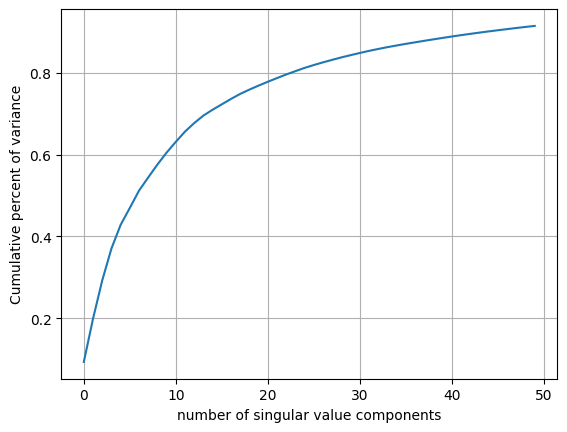

In [36]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [37]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

In [38]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

(310, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
49800017,0.159126,0.094781,0.074467,0.867845,0.104342,0.451602,0.152625,-0.047068,0.053521,0.675642,...,-0.054144,-0.001386,0.001673,-0.014539,-0.032776,-0.046553,-0.003990,-0.006586,-0.008821,0.013848
49800020,0.409155,-0.382170,0.576855,-0.308769,0.238508,0.484030,0.073801,0.038980,0.071821,0.701121,...,-0.062025,0.032970,0.001380,-0.005928,-0.031905,-0.049748,-0.003544,-0.002479,-0.001267,-0.018393
28401080,0.265688,0.819887,-0.069625,-0.261478,0.272532,0.385874,0.291194,0.005876,0.199421,0.596432,...,0.028100,-0.038054,0.001707,-0.009919,-0.007954,-0.004429,0.001134,-0.013930,-0.001824,0.022821
28719157,0.274873,0.828929,-0.039082,-0.235706,0.326835,0.626002,0.366783,0.021173,0.926960,-0.465166,...,-0.037969,0.034274,0.008204,-0.013873,-0.032816,-0.009436,-0.005809,-0.000520,-0.008383,-0.010194
28717170,0.424708,-0.360599,0.624793,-0.291207,0.327407,0.838738,0.194364,0.061150,1.015400,-0.473332,...,0.066887,-0.038853,-0.009329,0.014279,0.030873,0.015776,0.003073,0.008698,0.009427,-0.004989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901444,0.405871,-0.403868,0.573468,-0.335038,0.207657,0.363650,0.009501,0.043420,0.016501,0.069495,...,0.014190,-0.008252,-0.008739,0.017096,0.034980,-0.004330,0.030674,-0.004994,-0.078608,-0.038958
10400294,0.156276,0.073684,0.071730,0.851527,0.074652,0.338353,0.090313,-0.043913,-0.001854,0.045490,...,0.034045,-0.072023,-0.016857,0.019278,0.062489,0.005851,0.059783,-0.021020,-0.175056,-0.017577
10400334,0.406306,-0.403267,0.574117,-0.325087,0.208818,0.370782,0.011488,0.042135,0.016445,0.070969,...,0.026164,-0.037667,-0.017150,0.027889,0.063360,0.002656,0.060229,-0.016913,-0.167502,-0.049818
10400398,0.259958,0.803929,-0.085135,-0.281876,0.228669,0.213571,0.211477,0.002942,0.025685,0.052357,...,-0.027097,0.034181,0.012320,-0.050793,-0.136581,-0.044936,-0.121927,0.106145,0.496224,0.067421


In [39]:
latent_df_1.reset_index().drop_duplicates().shape

(310, 51)

In [40]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [41]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [42]:
df_event = preprocessing_event(df)
df_event.user_id.nunique()

186

In [43]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [44]:
df_event['rating'] = df_event['event_type'].map(dct)

In [45]:
df_event["rating"].sum()

743

In [46]:
# df_rating.shape

In [47]:
# df_rating = df_event.pivot_table(values='rating',
#                                  index='product_id',
#                                  columns='user_id',
#                                  aggfunc="sum").fillna(0)
# df_rating

In [48]:
df_event.nunique()

event_time       609
event_type         3
product_id       310
category_id       61
category_code     50
brand             98
price            364
user_id          186
user_session     186
rating             3
dtype: int64

In [49]:
df_event.drop_duplicates(subset='product_id',inplace=True)
df_event.nunique()

event_time       310
event_type         3
product_id       310
category_id       61
category_code     50
brand             98
price            290
user_id          147
user_session     147
rating             3
dtype: int64

In [50]:
%%time

df_rating = df_event.pivot(values='rating',
               index='product_id',
               columns='user_id').fillna(0)

df_rating

CPU times: user 13.9 ms, sys: 0 ns, total: 13.9 ms
Wall time: 9.94 ms


user_id,512483064,512600925,512652590,512843699,512845701,512893095,513035269,513160929,513192914,513196971,...,562786298,562883054,563195675,563543861,563842008,564098956,564555327,564879838,565847508,566031240
product_id,,,,,,,,,,,,,,,,,,,,,
1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df_rating.sum().reset_index()[0].sum()

324.0

In [52]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    324
dtype: int64

In [53]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    324
dtype: int64

In [54]:
df_rating.reset_index()

user_id,product_id,512483064,512600925,512652590,512843699,512845701,512893095,513035269,513160929,513192914,...,562786298,562883054,563195675,563543861,563842008,564098956,564555327,564879838,565847508,566031240
0,1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,49800017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
svd = TruncatedSVD(n_components=75)
latent_df_2 = svd.fit_transform(df_rating)

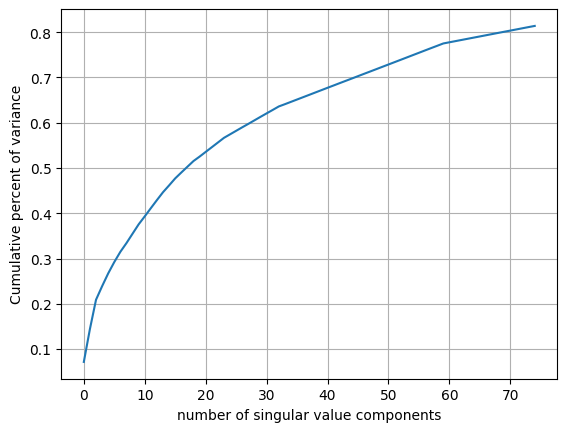

In [56]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [57]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
1002532,5.370299e-12,1.856028e-12,6.021176e-12,3.409748e-09,9.792528e-09,-3.712794e-09,6.779365e-09,-1.893951e-08,-6.767103e-08,-2.742798e-08,...,2.289835e-16,-1.144917e-16,1.372939e-16,-7.806256e-17,-9.714451e-17,1.283695e-16,-1.335737e-16,5.030698e-17,-1.769418e-16,4.597017e-17
1002540,5.370299e-12,1.856028e-12,6.021176e-12,3.409748e-09,9.792528e-09,-3.712794e-09,6.779365e-09,-1.893951e-08,-6.767103e-08,-2.742798e-08,...,2.289835e-16,-1.144917e-16,1.372939e-16,-7.806256e-17,-9.714451e-17,1.283695e-16,-1.335737e-16,5.030698e-17,-1.769418e-16,4.597017e-17
1002542,-4.591268e-10,-6.193865e-10,1.499653e-10,7.466931e-08,1.816939e-07,3.688287e-07,-1.606619e-07,1.832813e-07,-3.348046e-07,5.665075e-08,...,6.882455e-02,-1.891785e-01,-6.114031e-02,3.527055e-02,-7.220649e-04,9.234578e-02,8.848879e-02,2.292631e-01,1.193927e-01,3.789954e-02
1002544,-1.265333e-11,-1.078933e-11,-8.241978e-11,-2.786814e-09,2.854519e-09,1.613395e-08,1.998979e-10,1.140423e-08,-2.378380e-08,-3.167575e-08,...,1.023487e-16,6.938894e-18,-1.344411e-16,-2.428613e-17,9.367507e-17,-2.870967e-16,-1.318390e-16,-1.908196e-16,2.151057e-16,1.144917e-16
1002633,-1.265333e-11,-1.078933e-11,-8.241978e-11,-2.786814e-09,2.854519e-09,1.613395e-08,1.998979e-10,1.140423e-08,-2.378380e-08,-3.167575e-08,...,1.023487e-16,6.938894e-18,-1.344411e-16,-2.428613e-17,9.367507e-17,-2.870967e-16,-1.318390e-16,-1.908196e-16,2.151057e-16,1.144917e-16


In [58]:
latent_df_2.shape

(310, 75)

# Testing

In [6]:
filename_1 = '../data/oct_final/latent_df_1_with_100pct_data_50_svd_components_oct19.csv'

In [7]:
latent_df_1 = pd.read_csv(filename_1, index_col=[0])

In [8]:
latent_df_1.shape

(52817, 50)

In [9]:
filename_2 = '../data/oct_final/latent_df_2_with_100pct_data_100_svd_components_oct19.csv'

In [10]:
latent_df_2 = pd.read_csv(filename_2, index_col=[0])

In [11]:
latent_df_2.shape

(52817, 100)

In [12]:
filename_meta = '../data/oct_final/X_meta_with_100pct_data_oct19.csv'

In [13]:
X_meta = pd.read_csv(filename_meta, index_col=[0])

In [14]:
X_meta.shape

(5313956, 13)

In [15]:
X_meta=X_meta.reset_index().drop(columns='product_id.1')

In [16]:
X_meta.shape

(5313956, 13)

In [17]:
unique_prods_df = latent_df_1[["0"]].reset_index()[["index"]]
unique_prods_df.head()

,index
0,1000978
1,1001588
2,1001606
3,1002042
4,1002062


In [18]:
#unique_prods_df.merge(X_meta[["product_id"]], left_on="index", right_on="product_id")
X_meta = X_meta.merge(unique_prods_df, right_on="index", left_on="product_id").drop_duplicates("product_id")

In [19]:
X_meta.shape

(52817, 14)

# Apply Cosine Similarity in Content and Collaborative Matrices


In [31]:
product_id=1307366

In [32]:
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[product_id]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[product_id]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

In [33]:
dictDf_1 = {'features': sim1} 
recommendation_df_1 = pd.DataFrame(dictDf_1, index = latent_df_1.index)
# recommendation_df_1.sort_values('features', ascending=False, inplace=True)

In [34]:
recommendation_df_1.head()

,features
1000978,-0.004794
1001588,0.294703
1001606,0.019720
1002042,0.262886
1002062,0.262886


In [35]:
dictDf_2 = {'ratings': sim2} 
recommendation_df_2 = pd.DataFrame(dictDf_2, index = latent_df_2.index)
# recommendation_df_2.sort_values('ratings', ascending=False, inplace=True)

In [36]:
weight_features = 0.8

In [37]:
recommendation_combined = pd.merge(recommendation_df_1, recommendation_df_2, left_index=True, right_index=True)
recommendation_combined['hybrid'] = ((weight_features*recommendation_combined['features'] + (1-weight_features)*recommendation_combined['ratings']))

In [38]:
recommendation_combined.sort_values('ratings', ascending=False, inplace=True)
recommendation_combined

,features,ratings,hybrid
1307366,1.000000,1.000000,1.000000
16200414,0.004660,0.638314,0.131391
1801631,0.000730,0.596105,0.119805
18300580,0.002826,0.575962,0.117454
14100487,0.002482,0.565246,0.115035
...,...,...,...
4804001,-0.000189,-0.557531,-0.111657
3700566,0.002910,-0.561984,-0.110069
3701378,-0.002656,-0.561984,-0.114522
28401361,0.001350,-0.577976,-0.114516


In [39]:
recommendation_combined.sort_values(by='features', ascending=False)

,features,ratings,hybrid
1307366,1.000000,1.000000,1.000000
1307151,1.000000,-0.036686,0.792663
1306603,1.000000,0.118203,0.823641
1306004,1.000000,0.100277,0.820055
1307544,1.000000,-0.050810,0.789838
...,...,...,...
1003992,-0.014846,0.093179,0.006759
1003735,-0.014846,-0.111456,-0.034168
1003734,-0.014846,-0.088651,-0.029607
1003894,-0.014846,0.133721,0.014867


In [40]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inputs for ranking: 'features', 'ratings', 'hybrid'"""

    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    counter = 0
    
    product_ids=[]
    metas=[]
    prices=[]
    
    for i in feat_idx:
#         print(f"Product id {i}")
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        price = meta_df[meta_df['product_id'] == i][['price']].iloc[0,:][0]
        
#         if counter == 0:
#             print(f"Top {n} recommendations for product_id {product_id}:")
#             print(f"{i} - {meta_text} {price} \n")
#             print("-----------------------")

#         else:
#             print(f"Rec {counter}) {i} - {meta_text} {price}")
        
        product_ids.append(i)
        metas.append(meta_text)
        prices.append(price)
        
        counter += 1
    
    new_df = pd.DataFrame({'product_id':product_ids, 'meta_text':metas, 'price':prices}).drop_duplicates('meta_text').iloc[:n,:]
    return new_df.reset_index().drop(columns='index')

In [41]:
%%time

top_n_products(recommendation_combined, X_meta, ranking='hybrid', n=6)

Product id 1307366
Product id 1306796
Product id 1307264
Product id 1307140
Product id 1305901
Product id 1307316
Product id 1305321
Product id 1304473
Product id 1307197
Product id 1305627
Product id 1307310
Product id 1305263
Product id 1307478
Product id 1307545
Product id 45500000
Product id 45500001
Product id 45500013
Product id 45500012
Product id 45500009
Product id 1306400
Product id 1306603
Product id 1306004
Product id 1306561
Product id 45500011
Product id 1307005
Product id 1307004
Product id 1306220
Product id 1306818
Product id 1304392
Product id 1307236
Product id 1307238
Product id 45500015
Product id 1307271
Product id 45500022
Product id 45500008
Product id 1307010
Product id 1305208
Product id 45500002
Product id 1306947
Product id 45500006
Product id 45500016
Product id 1307151
Product id 45500014
Product id 1307370
Product id 1307544
Product id 1305332
Product id 1307068
Product id 1307438
Product id 1304995
Product id 1306063
Product id 1306653
Product id 1304736

Product id 1306999
Product id 30900444
Product id 1306535
Product id 6400342
Product id 1306978
Product id 1307477
Product id 1307402
Product id 1306351
Product id 1306929
Product id 1306534
Product id 17800121
Product id 1306873
Product id 1306865
Product id 1305877
Product id 1306869
Product id 1307395
Product id 1304511
Product id 1304644
Product id 11600107
Product id 1307450
Product id 1306868
Product id 1307210
Product id 1306562
Product id 1305883
Product id 1307430
Product id 1306476
Product id 1306588
Product id 1307196
Product id 1306218
Product id 1305074
Product id 1307468
Product id 1306542
Product id 1304297
Product id 1307257
Product id 30901126
Product id 1307152
Product id 1304849
Product id 1306361
Product id 1307278
Product id 1305975
Product id 1307353
Product id 1307022
Product id 1305471
Product id 1307222
Product id 1306406
Product id 1305977
Product id 1307096
Product id 1307072
Product id 1304739
Product id 1307071
Product id 11600026
Product id 1306651
Product

Product id 1305528
Product id 1306571
Product id 1306616
Product id 11600051
Product id 1480442
Product id 1304808
Product id 1307497
Product id 1305974
Product id 6601026
Product id 9200373
Product id 1307488
Product id 1306494
Product id 6600914
Product id 1307246
Product id 1307248
Product id 1307244
Product id 1306432
Product id 1306484
Product id 1306512
Product id 1307211
Product id 30901029
Product id 30901099
Product id 1306985
Product id 11600412
Product id 1306566
Product id 30901132
Product id 1307218
Product id 1306875
Product id 1304566
Product id 11600153
Product id 1307464
Product id 6600782
Product id 1307537
Product id 9000216
Product id 1303049
Product id 1307429
Product id 11600418
Product id 1307180
Product id 1306541
Product id 30900947
Product id 1307014
Product id 30901146
Product id 17800716
Product id 1306343
Product id 6600174
Product id 6600113
Product id 1701326
Product id 30901134
Product id 11600219
Product id 30900346
Product id 11600042
Product id 116000

Product id 21800203
Product id 9101039
Product id 30901110
Product id 17800696
Product id 1307486
Product id 1306839
Product id 1307443
Product id 1307356
Product id 11600002
Product id 21800090
Product id 1307481
Product id 1306648
Product id 9200768
Product id 1306537
Product id 30900009
Product id 30900572
Product id 9200605
Product id 30901083
Product id 9500023
Product id 1306318
Product id 6600880
Product id 30900838
Product id 9200025
Product id 1307129
Product id 1307127
Product id 1307398
Product id 6500848
Product id 6801115
Product id 6701261
Product id 6600876
Product id 1306769
Product id 1306240
Product id 1306760
Product id 9200177
Product id 30900580
Product id 1307523
Product id 11600423
Product id 1307077
Product id 9101074
Product id 9101017
Product id 1700948
Product id 9200649
Product id 1307437
Product id 11600163
Product id 21800166
Product id 11600011
Product id 9200545
Product id 1306846
Product id 9200131
Product id 30901022
Product id 6801285
Product id 30900

Product id 1306977
Product id 1305606
Product id 1306337
Product id 9200294
Product id 1307149
Product id 9200601
Product id 1306548
Product id 1307245
Product id 1307224
Product id 1307269
Product id 1701158
Product id 1307422
Product id 11600122
Product id 1700791
Product id 1701245
Product id 27600367
Product id 1307252
Product id 9100435
Product id 9101042
Product id 1305235
Product id 1307217
Product id 1306082
Product id 6500450
Product id 9100723
Product id 9200717
Product id 1306511
Product id 1307283
Product id 1306516
Product id 9100655
Product id 9100757
Product id 6801011
Product id 1700612
Product id 1306755
Product id 9200029
Product id 1305232
Product id 1306933
Product id 1307326
Product id 1307318
Product id 9101255
Product id 1306036
Product id 1307335
Product id 17800301
Product id 1700542
Product id 1700591
Product id 1305930
Product id 9101106
Product id 1305848
Product id 9100584
Product id 9101329
Product id 1700380
Product id 11600186
Product id 1307265
Product 

Product id 9100728
Product id 6600819
Product id 21800301
Product id 6500767
Product id 1701477
Product id 6500895
Product id 1201408
Product id 6501087
Product id 26900010
Product id 25800033
Product id 1480239
Product id 1700781
Product id 6700791
Product id 9101443
Product id 27600450
Product id 20200364
Product id 21800227
Product id 18500031
Product id 10201351
Product id 5200136
Product id 5200095
Product id 1600634
Product id 6600983
Product id 52300009
Product id 18301002
Product id 1500297
Product id 1500475
Product id 44800124
Product id 1701369
Product id 12100724
Product id 12100575
Product id 6600552
Product id 21800310
Product id 1480393
Product id 1701108
Product id 1480760
Product id 12100867
Product id 12100847
Product id 1480195
Product id 5200134
Product id 28500084
Product id 1600539
Product id 21800205
Product id 21800193
Product id 12100819
Product id 44800187
Product id 21800302
Product id 10200428
Product id 1500450
Product id 44800050
Product id 10200823
Produc

Product id 5200142
Product id 8800865
Product id 20200373
Product id 1201268
Product id 18500029
Product id 18500075
Product id 12100974
Product id 12100139
Product id 45601884
Product id 37700079
Product id 3100322
Product id 1201238
Product id 18300155
Product id 28713981
Product id 5200101
Product id 10201443
Product id 1201425
Product id 44800025
Product id 32200051
Product id 32200046
Product id 45300052
Product id 9002549
Product id 45601040
Product id 9100940
Product id 8801001
Product id 25800026
Product id 25001167
Product id 28711956
Product id 1480194
Product id 28719785
Product id 51700001
Product id 12100972
Product id 28300694
Product id 6801078
Product id 1201370
Product id 1480619
Product id 12100821
Product id 1701300
Product id 19300029
Product id 5200111
Product id 18500020
Product id 5801330
Product id 8800497
Product id 1480503
Product id 8800939
Product id 1480483
Product id 12100932
Product id 46500006
Product id 1600470
Product id 48200447
Product id 25800001
Pr

Product id 22400197
Product id 14500083
Product id 28500092
Product id 17800012
Product id 1701152
Product id 28717274
Product id 4000179
Product id 8902114
Product id 12100115
Product id 28719436
Product id 3801054
Product id 43300077
Product id 3800348
Product id 5000552
Product id 43300086
Product id 12100658
Product id 17000057
Product id 11300053
Product id 10201162
Product id 4600534
Product id 21411865
Product id 44400232
Product id 1201369
Product id 54900043
Product id 25001628
Product id 8800236
Product id 1004855
Product id 12100002
Product id 12100746
Product id 4803979
Product id 4801628
Product id 9100607
Product id 17000056
Product id 16200313
Product id 54900042
Product id 1004112
Product id 1003613
Product id 17800736
Product id 6801362
Product id 1201539
Product id 45600257
Product id 45600268
Product id 18500001
Product id 6600140
Product id 21411876
Product id 9002739
Product id 10201456
Product id 8800861
Product id 8801029
Product id 3100753
Product id 28711836
Pr

Product id 17800192
Product id 11100266
Product id 9002158
Product id 48200456
Product id 21411830
Product id 29502109
Product id 1480423
Product id 21406389
Product id 10201681
Product id 9200527
Product id 21800218
Product id 45600198
Product id 1701253
Product id 45600381
Product id 8800284
Product id 18300177
Product id 43300150
Product id 3100667
Product id 40900007
Product id 12100737
Product id 9100545
Product id 6800050
Product id 45602161
Product id 45602275
Product id 6701059
Product id 9700004
Product id 21408899
Product id 6400290
Product id 6400221
Product id 28721299
Product id 9200494
Product id 9700227
Product id 6400337
Product id 6400294
Product id 6400353
Product id 3800535
Product id 28717146
Product id 6800507
Product id 8902140
Product id 28711576
Product id 10201679
Product id 9700364
Product id 9700349
Product id 9200574
Product id 1401962
Product id 7004324
Product id 55000025
Product id 6801100
Product id 30901010
Product id 1700943
Product id 32900148
Product

Product id 17800299
Product id 14300261
Product id 5800704
Product id 28719778
Product id 19100023
Product id 5100376
Product id 1701156
Product id 6000032
Product id 30901135
Product id 30901130
Product id 45601259
Product id 6000163
Product id 28719750
Product id 9002983
Product id 45600282
Product id 45601362
Product id 43300154
Product id 19300076
Product id 18300066
Product id 18300250
Product id 1801584
Product id 8800351
Product id 8800488
Product id 17800020
Product id 30900357
Product id 9100515
Product id 30900119
Product id 6600378
Product id 9200176
Product id 9002038
Product id 1701383
Product id 40900030
Product id 28711961
Product id 6801010
Product id 4000111
Product id 4804073
Product id 10200003
Product id 8900076
Product id 6400363
Product id 53900047
Product id 16200372
Product id 6301562
Product id 28706720
Product id 30900107
Product id 28707877
Product id 18300109
Product id 10201054
Product id 21800276
Product id 55700155
Product id 3800497
Product id 3801168
Pr

Product id 43300109
Product id 28705652
Product id 3800537
Product id 21400533
Product id 21401280
Product id 21408947
Product id 21400538
Product id 12202548
Product id 28708229
Product id 3200589
Product id 1004672
Product id 6801372
Product id 5100800
Product id 6600761
Product id 45600243
Product id 12202075
Product id 6400339
Product id 45600705
Product id 1480169
Product id 21401236
Product id 14100630
Product id 44400216
Product id 6400329
Product id 7006567
Product id 25001057
Product id 6801148
Product id 30900846
Product id 28719739
Product id 1480387
Product id 30000069
Product id 18300627
Product id 28708832
Product id 17000063
Product id 12100536
Product id 6700920
Product id 11200532
Product id 45600847
Product id 56300079
Product id 56300075
Product id 18900386
Product id 6400314
Product id 28717179
Product id 28718031
Product id 3100764
Product id 28300722
Product id 13903429
Product id 1003843
Product id 21800097
Product id 21800075
Product id 17800725
Product id 10041

Product id 1003347
Product id 28719783
Product id 6100154
Product id 30901050
Product id 3600929
Product id 4000175
Product id 30900538
Product id 22600061
Product id 9100674
Product id 12900362
Product id 16200060
Product id 1480755
Product id 3801275
Product id 59300003
Product id 9700024
Product id 1004713
Product id 2300264
Product id 21404504
Product id 22600022
Product id 3801122
Product id 45602366
Product id 1700984
Product id 1003438
Product id 56300076
Product id 28706376
Product id 52800002
Product id 1004876
Product id 4804128
Product id 43300186
Product id 43300165
Product id 1004603
Product id 29100091
Product id 9700254
Product id 9001019
Product id 4900190
Product id 3701132
Product id 11000190
Product id 4200542
Product id 28720503
Product id 1480132
Product id 9100708
Product id 5100605
Product id 6701107
Product id 6600163
Product id 16200338
Product id 1701199
Product id 21402240
Product id 1201491
Product id 28704968
Product id 3800731
Product id 1004491
Product id

Product id 9200699
Product id 1004777
Product id 30901165
Product id 8901840
Product id 6701180
Product id 1701354
Product id 22900234
Product id 10201395
Product id 10201398
Product id 10201461
Product id 43300168
Product id 28721760
Product id 28704909
Product id 9000225
Product id 3601065
Product id 45601083
Product id 45601080
Product id 1004355
Product id 9200590
Product id 9200139
Product id 1600556
Product id 6400217
Product id 6400117
Product id 6400349
Product id 9101361
Product id 3601138
Product id 3601440
Product id 42900022
Product id 13600069
Product id 3801167
Product id 9200069
Product id 28719845
Product id 1480527
Product id 6100080
Product id 45600998
Product id 1600401
Product id 28701671
Product id 45600831
Product id 1004272
Product id 21800066
Product id 12100799
Product id 28709132
Product id 3800930
Product id 3601170
Product id 4801791
Product id 45601105
Product id 9101518
Product id 6700757
Product id 25100210
Product id 6800644
Product id 32900082
Product i

Product id 25900025
Product id 6700821
Product id 1005012
Product id 8800867
Product id 6500657
Product id 6200287
Product id 6701018
Product id 4501894
Product id 4801191
Product id 43300095
Product id 28710229
Product id 10201441
Product id 5100712
Product id 4803656
Product id 9001181
Product id 9002584
Product id 16200446
Product id 4400197
Product id 45600255
Product id 4700680
Product id 45600985
Product id 25001627
Product id 49800010
Product id 1480651
Product id 1005024
Product id 1201508
Product id 5100377
Product id 45600261
Product id 5100612
Product id 12202541
Product id 21402830
Product id 6600798
Product id 9200193
Product id 6400355
Product id 28721298
Product id 3601635
Product id 28703118
Product id 6400331
Product id 14100244
Product id 3700804
Product id 1005219
Product id 12200064
Product id 6800832
Product id 21409412
Product id 1401165
Product id 6800774
Product id 4804413
Product id 1005194
Product id 60500006
Product id 12300303
Product id 59600023
Product id 

Product id 21404570
Product id 21403774
Product id 21409056
Product id 28708419
Product id 55500002
Product id 18300999
Product id 1005197
Product id 12202452
Product id 28300085
Product id 39800147
Product id 4803793
Product id 17800017
Product id 6801055
Product id 21401666
Product id 28717395
Product id 4700544
Product id 6701115
Product id 28719677
Product id 1005222
Product id 28708375
Product id 8901058
Product id 8801024
Product id 8901310
Product id 28717174
Product id 30900312
Product id 45601086
Product id 5800218
Product id 21411690
Product id 6800309
Product id 30901080
Product id 1480772
Product id 6701119
Product id 6600923
Product id 45600472
Product id 9101304
Product id 19200029
Product id 12202634
Product id 6600970
Product id 8902143
Product id 1802033
Product id 30900637
Product id 45601476
Product id 59600039
Product id 2800042
Product id 2702472
Product id 52900164
Product id 6301908
Product id 28717185
Product id 28715767
Product id 8800489
Product id 3700746
Pro

Product id 1401643
Product id 45600572
Product id 8800612
Product id 9700380
Product id 9101569
Product id 4200510
Product id 12300902
Product id 12300901
Product id 1801830
Product id 1480546
Product id 45600054
Product id 14701201
Product id 28717067
Product id 1004743
Product id 4801739
Product id 8801011
Product id 45600462
Product id 9700318
Product id 28720425
Product id 12201331
Product id 7000641
Product id 28715060
Product id 28701670
Product id 28715223
Product id 28715227
Product id 28719056
Product id 6500607
Product id 9200354
Product id 6201322
Product id 21400527
Product id 21410423
Product id 4700631
Product id 9200701
Product id 7101897
Product id 3701243
Product id 4800437
Product id 9200073
Product id 45600343
Product id 45601068
Product id 6300656
Product id 14700465
Product id 45602280
Product id 6700905
Product id 21411765
Product id 1701372
Product id 4700675
Product id 12202657
Product id 1701391
Product id 45601207
Product id 3601560
Product id 3601561
Product 

Product id 8801025
Product id 30900736
Product id 45600630
Product id 45601172
Product id 1003153
Product id 45601846
Product id 13500041
Product id 9200750
Product id 16200451
Product id 21800120
Product id 28500087
Product id 21411888
Product id 21411769
Product id 45602197
Product id 28300702
Product id 1701540
Product id 12200600
Product id 30900130
Product id 28717428
Product id 17800540
Product id 37700068
Product id 30901066
Product id 47200195
Product id 9200673
Product id 11700274
Product id 10201084
Product id 6500910
Product id 45601338
Product id 7000271
Product id 7000278
Product id 43300200
Product id 6501095
Product id 1005007
Product id 9100390
Product id 18300151
Product id 3600931
Product id 1480518
Product id 18200071
Product id 2702538
Product id 45600785
Product id 4804626
Product id 1701142
Product id 12900055
Product id 12900390
Product id 4400168
Product id 4802424
Product id 6800859
Product id 6800015
Product id 17800022
Product id 10900017
Product id 17800212


Product id 28713632
Product id 25100331
Product id 2501816
Product id 4502304
Product id 13200293
Product id 9700287
Product id 28705932
Product id 14701919
Product id 1004566
Product id 9002414
Product id 3601272
Product id 6701098
Product id 35200627
Product id 4700661
Product id 4700660
Product id 9002008
Product id 45601000
Product id 1003622
Product id 9001861
Product id 55500003
Product id 45600684
Product id 1401872
Product id 45600040
Product id 1701244
Product id 6600654
Product id 3601529
Product id 8800890
Product id 9700377
Product id 28713980
Product id 1004190
Product id 17800037
Product id 17800035
Product id 6301727
Product id 28705239
Product id 12202465
Product id 3701468
Product id 28713120
Product id 28710354
Product id 45600001
Product id 6801278
Product id 28714937
Product id 9200591
Product id 21401326
Product id 28718211
Product id 1480660
Product id 1004963
Product id 1480491
Product id 9700327
Product id 9101527
Product id 53900024
Product id 21403779
Product 

Product id 4501190
Product id 8901976
Product id 7006356
Product id 28715294
Product id 28711935
Product id 1003984
Product id 6800993
Product id 7101738
Product id 8700249
Product id 9001968
Product id 6800561
Product id 21401316
Product id 35200009
Product id 1401562
Product id 6801400
Product id 4200878
Product id 30000112
Product id 21411131
Product id 21408938
Product id 21404249
Product id 11200456
Product id 4804032
Product id 28710655
Product id 28717123
Product id 28721301
Product id 3900712
Product id 9100173
Product id 1700881
Product id 1701226
Product id 1700952
Product id 9101532
Product id 1480168
Product id 9101225
Product id 9101643
Product id 1600637
Product id 28300498
Product id 3601445
Product id 28710991
Product id 8901795
Product id 4000176
Product id 21408949
Product id 9101242
Product id 6302111
Product id 21401377
Product id 6200514
Product id 6500981
Product id 43200113
Product id 28705146
Product id 48100007
Product id 1003789
Product id 6902379
Product id 6

Product id 21401365
Product id 1480652
Product id 4802237
Product id 12201755
Product id 30901065
Product id 30900911
Product id 30901064
Product id 28717429
Product id 21408934
Product id 9001276
Product id 9001951
Product id 27700780
Product id 9101372
Product id 9002105
Product id 6701189
Product id 28711784
Product id 9101478
Product id 12600086
Product id 28300730
Product id 8800775
Product id 6601047
Product id 3100363
Product id 4400406
Product id 6600775
Product id 4804252
Product id 4801329
Product id 9101270
Product id 1401651
Product id 28717222
Product id 11100226
Product id 45600645
Product id 19100258
Product id 3601403
Product id 2501375
Product id 8902047
Product id 28707516
Product id 9101383
Product id 21800118
Product id 1480757
Product id 21401372
Product id 6902894
Product id 13900312
Product id 28711802
Product id 53900034
Product id 21409466
Product id 21409272
Product id 45600271
Product id 6400361
Product id 11700447
Product id 28700178
Product id 6801160
Produ

Product id 8902148
Product id 45600220
Product id 7006267
Product id 2501228
Product id 1003073
Product id 22600019
Product id 6800866
Product id 6801292
Product id 3900739
Product id 1004691
Product id 4801835
Product id 38000013
Product id 30900931
Product id 6301658
Product id 5801396
Product id 6801368
Product id 18300176
Product id 43300091
Product id 4700671
Product id 9100971
Product id 4802619
Product id 3700600
Product id 16200206
Product id 2800629
Product id 21400381
Product id 18300215
Product id 9002798
Product id 7006265
Product id 17800276
Product id 28719742
Product id 6801185
Product id 28715831
Product id 45601101
Product id 1004613
Product id 2702256
Product id 28711680
Product id 13500286
Product id 28710765
Product id 5800311
Product id 6800526
Product id 6800557
Product id 6301511
Product id 6701035
Product id 28713535
Product id 6600489
Product id 43300089
Product id 21401994
Product id 25100105
Product id 21402237
Product id 1480734
Product id 1480731
Product id

Product id 21800004
Product id 4804559
Product id 1480134
Product id 6500756
Product id 9200522
Product id 21800007
Product id 23700007
Product id 21400674
Product id 6800327
Product id 9101410
Product id 14701852
Product id 7006208
Product id 3600453
Product id 3600450
Product id 1701468
Product id 21401509
Product id 21401508
Product id 4802520
Product id 9200113
Product id 9500131
Product id 9100560
Product id 18301073
Product id 21410874
Product id 4802855
Product id 1003608
Product id 14300188
Product id 21404467
Product id 25100092
Product id 21411666
Product id 9700405
Product id 6400350
Product id 21403078
Product id 4700274
Product id 9900454
Product id 1004830
Product id 8700255
Product id 9700229
Product id 8900691
Product id 21402206
Product id 4802272
Product id 28715858
Product id 9100239
Product id 4804539
Product id 12901271
Product id 1802101
Product id 28705121
Product id 28708376
Product id 14701292
Product id 4803245
Product id 1801639
Product id 45600790
Product id

Product id 6500732
Product id 21410327
Product id 4804219
Product id 17800704
Product id 6500992
Product id 9100857
Product id 9002949
Product id 5700619
Product id 11200349
Product id 45601460
Product id 5801621
Product id 17800293
Product id 4000195
Product id 21408678
Product id 4501651
Product id 6801329
Product id 9001493
Product id 6700963
Product id 9101432
Product id 13901474
Product id 6701036
Product id 5100700
Product id 28712086
Product id 1004432
Product id 6700940
Product id 28714875
Product id 28708545
Product id 28714900
Product id 2401588
Product id 6301904
Product id 45601084
Product id 5800128
Product id 6601097
Product id 4803990
Product id 21800037
Product id 45602035
Product id 14701847
Product id 13800414
Product id 1701461
Product id 25100309
Product id 8700233
Product id 4804446
Product id 16800034
Product id 16800033
Product id 6700956
Product id 10900299
Product id 13900910
Product id 11200430
Product id 9002581
Product id 6600741
Product id 6600562
Product i

Product id 5800730
Product id 5800775
Product id 4801192
Product id 6100107
Product id 1005204
Product id 9002938
Product id 14300341
Product id 25900009
Product id 28715268
Product id 2402951
Product id 1005210
Product id 4801844
Product id 14701835
Product id 1004156
Product id 9100574
Product id 6902914
Product id 5800746
Product id 21409410
Product id 1480670
Product id 21405683
Product id 21409429
Product id 9200255
Product id 9200596
Product id 21411665
Product id 6600463
Product id 21410848
Product id 6800780
Product id 4501569
Product id 1003645
Product id 9101406
Product id 28701686
Product id 6200570
Product id 1480353
Product id 21800170
Product id 7102069
Product id 2300249
Product id 45600840
Product id 4802394
Product id 6801311
Product id 28710994
Product id 28707876
Product id 12300075
Product id 2701687
Product id 1701559
Product id 1701015
Product id 4801135
Product id 28715860
Product id 28705127
Product id 3601450
Product id 3100341
Product id 4804397
Product id 680

Product id 28711746
Product id 28711673
Product id 28711722
Product id 28711843
Product id 4802024
Product id 8700570
Product id 6700608
Product id 4600657
Product id 13600024
Product id 28718086
Product id 28705243
Product id 35200003
Product id 2400648
Product id 1801306
Product id 6301982
Product id 9101531
Product id 1480293
Product id 28718097
Product id 28708230
Product id 1480036
Product id 28721771
Product id 1003910
Product id 9100617
Product id 45601347
Product id 21404542
Product id 1600542
Product id 21800154
Product id 21407700
Product id 21401430
Product id 21400187
Product id 6801369
Product id 9101145
Product id 5800003
Product id 5801384
Product id 5800097
Product id 21403652
Product id 21403926
Product id 6500821
Product id 2400666
Product id 46800015
Product id 1700628
Product id 1004038
Product id 21410422
Product id 3600145
Product id 28715836
Product id 8902590
Product id 11700458
Product id 1701443
Product id 6600812
Product id 1701200
Product id 12300489
Product

Product id 45601361
Product id 28707163
Product id 28708081
Product id 9002025
Product id 9200672
Product id 13200011
Product id 4500513
Product id 1401566
Product id 9002395
Product id 17000053
Product id 28706500
Product id 9002410
Product id 12300752
Product id 2701560
Product id 21401739
Product id 4801787
Product id 1500466
Product id 9101360
Product id 3601443
Product id 45600486
Product id 45600227
Product id 45600223
Product id 4700676
Product id 1004089
Product id 28708546
Product id 4501337
Product id 25100133
Product id 21402850
Product id 6100067
Product id 1480579
Product id 5800620
Product id 5801564
Product id 5801508
Product id 6800520
Product id 9101187
Product id 9700215
Product id 4803188
Product id 1600547
Product id 2800613
Product id 21404528
Product id 1480437
Product id 5800161
Product id 1401567
Product id 4804196
Product id 21408686
Product id 3700504
Product id 6801294
Product id 28714889
Product id 3701077
Product id 3701404
Product id 1500464
Product id 910

Product id 27700842
Product id 27700804
Product id 9002939
Product id 21401315
Product id 52900126
Product id 6600932
Product id 4801038
Product id 6500859
Product id 40900036
Product id 4803163
Product id 4800799
Product id 9100761
Product id 9101269
Product id 21409527
Product id 1004998
Product id 9700043
Product id 9101217
Product id 6700952
Product id 13900049
Product id 13900048
Product id 1701472
Product id 1003184
Product id 28719693
Product id 47200186
Product id 12300250
Product id 9100975
Product id 3601060
Product id 9001383
Product id 6601061
Product id 2401829
Product id 6400301
Product id 9200580
Product id 28708977
Product id 6300605
Product id 45600841
Product id 21401819
Product id 28716705
Product id 28716703
Product id 4800775
Product id 12301287
Product id 9002341
Product id 12300845
Product id 5700799
Product id 21402872
Product id 21402875
Product id 29502738
Product id 5800861
Product id 4801691
Product id 6700982
Product id 21403860
Product id 27701171
Product 

Product id 2800614
Product id 2800501
Product id 5801470
Product id 4502260
Product id 6801123
Product id 17800038
Product id 14300312
Product id 28721783
Product id 28705694
Product id 1701446
Product id 7101812
Product id 7101693
Product id 6301256
Product id 4700042
Product id 28718141
Product id 6500948
Product id 17000001
Product id 30900028
Product id 4801283
Product id 3601230
Product id 28711877
Product id 3601091
Product id 6701074
Product id 28712046
Product id 45600503
Product id 7101843
Product id 28708568
Product id 2800661
Product id 21409530
Product id 7901111
Product id 7000277
Product id 4803984
Product id 28720739
Product id 4800856
Product id 28715780
Product id 3900398
Product id 35200033
Product id 7006198
Product id 5100829
Product id 28709197
Product id 28711630
Product id 8901143
Product id 28714942
Product id 1003143
Product id 9002040
Product id 28712663
Product id 28718020
Product id 1701512
Product id 1701268
Product id 1700968
Product id 8902445
Product id 

Product id 1701309
Product id 6501044
Product id 9101396
Product id 9101156
Product id 12300292
Product id 14701966
Product id 45601614
Product id 6700781
Product id 1500444
Product id 1500253
Product id 4801271
Product id 21401472
Product id 21404263
Product id 21406320
Product id 21409433
Product id 21404559
Product id 21406335
Product id 21407356
Product id 21401340
Product id 21401433
Product id 9002924
Product id 9200413
Product id 6301492
Product id 6500612
Product id 6800900
Product id 14701884
Product id 9100768
Product id 21409360
Product id 1480657
Product id 1400888
Product id 1600328
Product id 1600589
Product id 6902493
Product id 21402193
Product id 1600466
Product id 21409521
Product id 6601072
Product id 6701017
Product id 9200469
Product id 6801406
Product id 21401299
Product id 1005089
Product id 21409432
Product id 4804363
Product id 1480176
Product id 45600954
Product id 1701424
Product id 8901006
Product id 9001966
Product id 9000788
Product id 9001957
Product id 9

Product id 28300875
Product id 4801607
Product id 6600783
Product id 6200717
Product id 21403672
Product id 21403290
Product id 28703068
Product id 45600921
Product id 9101226
Product id 6100198
Product id 12301284
Product id 9100609
Product id 2401880
Product id 4800713
Product id 21409317
Product id 6500716
Product id 6500789
Product id 28713994
Product id 1701082
Product id 4801466
Product id 28707350
Product id 12300993
Product id 28710827
Product id 2800428
Product id 8902136
Product id 1701105
Product id 28717022
Product id 28710362
Product id 6100211
Product id 4803917
Product id 4802957
Product id 4801749
Product id 6800308
Product id 6800383
Product id 4500249
Product id 28710797
Product id 9101229
Product id 3701465
Product id 4803980
Product id 4803169
Product id 28718208
Product id 9200708
Product id 28718207
Product id 21401732
Product id 7101460
Product id 35200038
Product id 6700552
Product id 4801689
Product id 21401494
Product id 4201411
Product id 6500693
Product id 4

Product id 1004138
Product id 4801310
Product id 3901044
Product id 9002848
Product id 9002851
Product id 9002849
Product id 9002858
Product id 4801678
Product id 4802269
Product id 37700078
Product id 28715834
Product id 2800156
Product id 6700805
Product id 11700406
Product id 11100149
Product id 6400161
Product id 1480553
Product id 13500367
Product id 28716626
Product id 2400380
Product id 6500995
Product id 6501018
Product id 4804152
Product id 3600912
Product id 6701136
Product id 3700647
Product id 1701056
Product id 3900217
Product id 1004863
Product id 9100267
Product id 7101421
Product id 7101900
Product id 4800712
Product id 7101046
Product id 6501106
Product id 1004518
Product id 19100064
Product id 4804424
Product id 12300238
Product id 3701442
Product id 21800023
Product id 6801344
Product id 13900374
Product id 6801122
Product id 21404529
Product id 28710828
Product id 45600231
Product id 4801885
Product id 1500298
Product id 1701522
Product id 1801084
Product id 9101412

Product id 28710789
Product id 21407840
Product id 6500497
Product id 7101692
Product id 45601782
Product id 4803531
Product id 1004757
Product id 6701049
Product id 21404273
Product id 1004596
Product id 6200640
Product id 21410843
Product id 9101633
Product id 1003572
Product id 1480374
Product id 7006205
Product id 4700454
Product id 3100202
Product id 9100538
Product id 9001987
Product id 6701114
Product id 53900037
Product id 5800680
Product id 5800726
Product id 28716618
Product id 28711941
Product id 8902557
Product id 12201759
Product id 14100211
Product id 21401222
Product id 4600623
Product id 28706501
Product id 16200012
Product id 28701775
Product id 19200017
Product id 14700075
Product id 1700893
Product id 9002333
Product id 6601042
Product id 4700569
Product id 6300361
Product id 8700313
Product id 1600613
Product id 1600628
Product id 1480335
Product id 1701527
Product id 1004708
Product id 3600760
Product id 27700132
Product id 21408948
Product id 4802680
Product id 14

Product id 1701377
Product id 28717053
Product id 6902988
Product id 1701025
Product id 5801550
Product id 7101800
Product id 3601284
Product id 10900006
Product id 28707243
Product id 6501108
Product id 6500970
Product id 4800879
Product id 4801258
Product id 28713324
Product id 5800731
Product id 7101417
Product id 9100403
Product id 12202393
Product id 9101157
Product id 28717132
Product id 45601515
Product id 1480280
Product id 6700946
Product id 9002412
Product id 1701289
Product id 6700613
Product id 9101092
Product id 14100441
Product id 11200064
Product id 6701037
Product id 6700597
Product id 1701500
Product id 13900202
Product id 13903272
Product id 6800493
Product id 6600580
Product id 1701297
Product id 9200089
Product id 28716204
Product id 4802239
Product id 4804182
Product id 4800783
Product id 1801514
Product id 4700727
Product id 6600813
Product id 6600760
Product id 6601067
Product id 6500833
Product id 6501066
Product id 21407693
Product id 13500288
Product id 287116

Product id 1701470
Product id 28706797
Product id 1701503
Product id 9101577
Product id 2401699
Product id 28708983
Product id 12300452
Product id 4800688
Product id 1600065
Product id 21407632
Product id 12300513
Product id 13900043
Product id 4800668
Product id 1700998
Product id 9002023
Product id 1500341
Product id 9101408
Product id 28719730
Product id 28719706
Product id 4802299
Product id 5801620
Product id 4700388
Product id 18300733
Product id 1600582
Product id 4802785
Product id 13500239
Product id 21401270
Product id 1701251
Product id 9101234
Product id 6501116
Product id 6201362
Product id 28716596
Product id 1801393
Product id 6301973
Product id 21402673
Product id 28717032
Product id 9100466
Product id 27700853
Product id 4801795
Product id 12301360
Product id 9100039
Product id 9100038
Product id 9100114
Product id 13900072
Product id 21401483
Product id 6700875
Product id 6700879
Product id 6700876
Product id 4801726
Product id 1201240
Product id 28708231
Product id 4

Product id 13500062
Product id 21800005
Product id 6700794
Product id 1500267
Product id 1500336
Product id 1201229
Product id 28705661
Product id 1701190
Product id 1600617
Product id 28718084
Product id 1201317
Product id 6500835
Product id 6500894
Product id 4802405
Product id 14300342
Product id 18300968
Product id 9100345
Product id 1201324
Product id 4804553
Product id 21800222
Product id 9101195
Product id 28708003
Product id 1480410
Product id 28711677
Product id 4801744
Product id 18300694
Product id 27700841
Product id 28712614
Product id 1500031
Product id 1500362
Product id 4800774
Product id 28718088
Product id 1500301
Product id 12100606
Product id 2701672
Product id 2702056
Product id 6500830
Product id 6500941
Product id 1701183
Product id 6501096
Product id 1801631
Product id 18300046
Product id 14701480
Product id 1201284
Product id 2501364
Product id 6500660
Product id 18300988
Product id 18300580
Product id 4801153
Product id 1801605
Product id 6500167
Product id 18

Product id 2702638
Product id 44800070
Product id 44800135
Product id 44800091
Product id 44800088
Product id 44800083
Product id 44800079
Product id 44800136
Product id 44800100
Product id 44800097
Product id 44800195
Product id 44800163
Product id 44800102
Product id 3100788
Product id 2701403
Product id 28714310
Product id 6100223
Product id 21407015
Product id 12300550
Product id 19200136
Product id 1201454
Product id 1200382
Product id 44800156
Product id 44800129
Product id 44800112
Product id 2100016
Product id 12300570
Product id 23700002
Product id 10201512
Product id 22600016
Product id 1201366
Product id 21410990
Product id 21406349
Product id 4900359
Product id 1005073
Product id 13200367
Product id 2702451
Product id 40900073
Product id 21403326
Product id 3701135
Product id 35104460
Product id 3100683
Product id 18500051
Product id 21408557
Product id 3900440
Product id 3901134
Product id 6901894
Product id 7004521
Product id 12202375
Product id 21410256
Product id 121007

Product id 5100698
Product id 4804003
Product id 12202396
Product id 22400032
Product id 28717999
Product id 6902899
Product id 48200459
Product id 13902088
Product id 3901051
Product id 35108959
Product id 28720658
Product id 1201405
Product id 21403113
Product id 5100657
Product id 28718239
Product id 1801658
Product id 3100225
Product id 21400793
Product id 2501500
Product id 5801524
Product id 1003313
Product id 2900006
Product id 4201505
Product id 2900852
Product id 3601424
Product id 2500638
Product id 45300021
Product id 1201374
Product id 28718678
Product id 28719528
Product id 30600125
Product id 4501113
Product id 2300295
Product id 1003328
Product id 8902617
Product id 3900754
Product id 28714061
Product id 28711851
Product id 27701184
Product id 53900029
Product id 18500079
Product id 5801239
Product id 1002538
Product id 5801485
Product id 21407260
Product id 50600059
Product id 3900985
Product id 21409249
Product id 6301426
Product id 2800535
Product id 17900063
Product 

Product id 21406712
Product id 21407409
Product id 7900022
Product id 12201670
Product id 22400176
Product id 28704634
Product id 28704642
Product id 7004001
Product id 28719470
Product id 12201908
Product id 28707774
Product id 4600502
Product id 10201451
Product id 14100285
Product id 2500768
Product id 2500727
Product id 2501848
Product id 37600060
Product id 3701117
Product id 21400080
Product id 20200335
Product id 20200341
Product id 2402312
Product id 28719289
Product id 4802443
Product id 13901825
Product id 16900046
Product id 28704600
Product id 28704607
Product id 28718862
Product id 7001198
Product id 1201532
Product id 5100906
Product id 28721504
Product id 1201451
Product id 20500366
Product id 2701837
Product id 35100522
Product id 11100084
Product id 21406379
Product id 26900024
Product id 3601325
Product id 5800658
Product id 3200041
Product id 11700018
Product id 4500873
Product id 28719447
Product id 4500799
Product id 12400057
Product id 4803771
Product id 12300819


Product id 30500014
Product id 3700818
Product id 2401925
Product id 8700594
Product id 10201850
Product id 10400401
Product id 4803836
Product id 9900141
Product id 12400478
Product id 19100383
Product id 2401457
Product id 12900384
Product id 25100006
Product id 1201392
Product id 5000134
Product id 10201203
Product id 4700435
Product id 12202163
Product id 5100684
Product id 13900837
Product id 21400952
Product id 13901576
Product id 4502115
Product id 28300708
Product id 4600585
Product id 2402479
Product id 5100593
Product id 6301852
Product id 27700504
Product id 28715766
Product id 2402006
Product id 28718879
Product id 3701369
Product id 19100421
Product id 21000003
Product id 2500548
Product id 4600651
Product id 12202327
Product id 9900031
Product id 13900080
Product id 25100031
Product id 25100024
Product id 28719075
Product id 53900019
Product id 3801360
Product id 6201056
Product id 16700973
Product id 55700122
Product id 4804483
Product id 6902322
Product id 22900063
Prod

Product id 21406420
Product id 21406459
Product id 21406505
Product id 45600441
Product id 21401358
Product id 1004930
Product id 4804316
Product id 21402851
Product id 21402860
Product id 21402512
Product id 28716474
Product id 12100374
Product id 1005208
Product id 45601311
Product id 32900001
Product id 28400721
Product id 13900549
Product id 21404659
Product id 17200951
Product id 28720663
Product id 28718341
Product id 2501940
Product id 5800019
Product id 13900672
Product id 13900679
Product id 13900766
Product id 4501780
Product id 4501852
Product id 28719109
Product id 3701188
Product id 19200064
Product id 28400126
Product id 13901813
Product id 2700648
Product id 28713435
Product id 14100540
Product id 2500223
Product id 21409887
Product id 1003765
Product id 1003760
Product id 16800238
Product id 21404281
Product id 8902662
Product id 6902503
Product id 35104355
Product id 3700911
Product id 3701294
Product id 6301123
Product id 1200519
Product id 18900443
Product id 1220195

Product id 14300294
Product id 16800035
Product id 10900348
Product id 1801697
Product id 12300769
Product id 5000069
Product id 5000478
Product id 18900001
Product id 13900941
Product id 8800801
Product id 8800955
Product id 28715628
Product id 7004790
Product id 2702111
Product id 7005148
Product id 3800934
Product id 6902913
Product id 45300035
Product id 45300042
Product id 36000049
Product id 47500011
Product id 21408260
Product id 21409713
Product id 13901375
Product id 4600356
Product id 1802013
Product id 1801748
Product id 44800139
Product id 10400438
Product id 23700020
Product id 48200399
Product id 17200297
Product id 1003549
Product id 28720965
Product id 28719492
Product id 45600405
Product id 7006415
Product id 12900704
Product id 1005143
Product id 9002821
Product id 21406770
Product id 2300268
Product id 28300638
Product id 3801094
Product id 28400545
Product id 28300533
Product id 28714638
Product id 2500558
Product id 3800192
Product id 14300019
Product id 28715680
P

Product id 2800658
Product id 48200451
Product id 11700445
Product id 18300983
Product id 4502253
Product id 2702130
Product id 14701217
Product id 8700311
Product id 2401872
Product id 13900762
Product id 8902285
Product id 2401059
Product id 28717341
Product id 30000272
Product id 16800308
Product id 44800172
Product id 28705522
Product id 1201516
Product id 21400158
Product id 12202282
Product id 13900731
Product id 12400386
Product id 21408748
Product id 1802074
Product id 4802526
Product id 30000007
Product id 35108802
Product id 28400862
Product id 19100177
Product id 28704311
Product id 3100975
Product id 4802354
Product id 18900137
Product id 18300432
Product id 11700321
Product id 2400404
Product id 2402907
Product id 4500212
Product id 13900193
Product id 17900080
Product id 3700554
Product id 3700298
Product id 43200090
Product id 2700184
Product id 12201588
Product id 16700594
Product id 28716845
Product id 21410880
Product id 5700567
Product id 4502749
Product id 14100213


Product id 2700282
Product id 16200428
Product id 12201632
Product id 12202708
Product id 9002324
Product id 28401038
Product id 21402125
Product id 12300700
Product id 19300009
Product id 28721766
Product id 4600613
Product id 21402646
Product id 21400274
Product id 12202825
Product id 12202846
Product id 51000033
Product id 21409880
Product id 21405957
Product id 21401783
Product id 21410515
Product id 2502093
Product id 6301329
Product id 2402945
Product id 4500951
Product id 12300731
Product id 2240000
Product id 2240030
Product id 19300067
Product id 2800190
Product id 11700422
Product id 2501801
Product id 12400062
Product id 28720073
Product id 45601189
Product id 2400635
Product id 2400730
Product id 11700082
Product id 6201347
Product id 21411658
Product id 4501654
Product id 2501739
Product id 21409899
Product id 5800634
Product id 7003777
Product id 19200179
Product id 28715994
Product id 4803396
Product id 12202428
Product id 28717145
Product id 5700200
Product id 28718620


Product id 35102642
Product id 35100764
Product id 35108614
Product id 35108766
Product id 35100736
Product id 21411733
Product id 21409144
Product id 21409138
Product id 21408971
Product id 21411265
Product id 21409140
Product id 21409142
Product id 12300959
Product id 7006370
Product id 3701248
Product id 45601535
Product id 28721716
Product id 4201390
Product id 4400443
Product id 5100346
Product id 21411288
Product id 28712684
Product id 3901157
Product id 7001227
Product id 1004363
Product id 5000783
Product id 2401234
Product id 21404225
Product id 21403909
Product id 12202836
Product id 12301542
Product id 6200892
Product id 4803360
Product id 4804396
Product id 3700915
Product id 12301133
Product id 12301124
Product id 13901865
Product id 9002048
Product id 18300438
Product id 28718468
Product id 45601025
Product id 27700115
Product id 4400061
Product id 6200020
Product id 4502130
Product id 28716842
Product id 21401387
Product id 28720851
Product id 6901132
Product id 35102282

Product id 21400753
Product id 9002783
Product id 28718730
Product id 5801030
Product id 7006146
Product id 7900212
Product id 28716945
Product id 2402805
Product id 7900615
Product id 3600659
Product id 3600965
Product id 3600632
Product id 2400298
Product id 2502131
Product id 8902399
Product id 28711619
Product id 28711569
Product id 21407933
Product id 22400221
Product id 8902435
Product id 8901604
Product id 5801614
Product id 12301538
Product id 12202874
Product id 21407591
Product id 12901518
Product id 4700565
Product id 6902451
Product id 2501014
Product id 12400249
Product id 4502678
Product id 4800537
Product id 1004741
Product id 35100850
Product id 3800888
Product id 2402426
Product id 16700807
Product id 7003550
Product id 4502680
Product id 28714789
Product id 35100834
Product id 1801795
Product id 9900402
Product id 17900296
Product id 12202361
Product id 7004940
Product id 29600022
Product id 21406360
Product id 7900635
Product id 21401061
Product id 22400251
Product i

Product id 6200013
Product id 45601601
Product id 8700532
Product id 28712868
Product id 5800637
Product id 36000076
Product id 28721039
Product id 28721294
Product id 2701166
Product id 2800657
Product id 8800729
Product id 17900033
Product id 2702197
Product id 35104135
Product id 35103821
Product id 12900902
Product id 55700053
Product id 2501967
Product id 4201037
Product id 8800384
Product id 21404878
Product id 21407014
Product id 21407398
Product id 16800314
Product id 20500287
Product id 28400503
Product id 16200478
Product id 28720975
Product id 5801063
Product id 1201395
Product id 1201383
Product id 6902034
Product id 1004386
Product id 6902370
Product id 16800317
Product id 21407246
Product id 28714174
Product id 6300299
Product id 10900192
Product id 19200037
Product id 1004452
Product id 6301429
Product id 21405232
Product id 3200509
Product id 6201190
Product id 21407004
Product id 28718629
Product id 35103731
Product id 5100599
Product id 12100992
Product id 28719162
Pr

Product id 1801706
Product id 18900138
Product id 39800042
Product id 28300235
Product id 7005004
Product id 23700047
Product id 7004220
Product id 13600189
Product id 21411475
Product id 21411486
Product id 21409893
Product id 21401006
Product id 28401315
Product id 28401328
Product id 47500015
Product id 21410905
Product id 21410899
Product id 7004232
Product id 7004868
Product id 7005305
Product id 7004009
Product id 35103007
Product id 28720548
Product id 35104262
Product id 45300023
Product id 3100117
Product id 18300028
Product id 35102555
Product id 8700037
Product id 2502126
Product id 21411534
Product id 12300790
Product id 2401530
Product id 2402502
Product id 4000137
Product id 21407673
Product id 22900344
Product id 28712251
Product id 35200182
Product id 18900013
Product id 35108653
Product id 18300277
Product id 39700137
Product id 12201668
Product id 12201701
Product id 12201697
Product id 28717977
Product id 28714176
Product id 12200909
Product id 12200945
Product id 14

Product id 21411320
Product id 4803439
Product id 28721128
Product id 27600431
Product id 3601597
Product id 4804135
Product id 2501694
Product id 4400542
Product id 28721486
Product id 7900966
Product id 28712916
Product id 28714369
Product id 28719615
Product id 28717286
Product id 30500017
Product id 18300854
Product id 21401345
Product id 21406430
Product id 3700943
Product id 28711850
Product id 10400525
Product id 1201407
Product id 28718664
Product id 9002348
Product id 28717978
Product id 21405977
Product id 37600058
Product id 6100201
Product id 2900326
Product id 44400199
Product id 16700073
Product id 1201507
Product id 12202147
Product id 21406569
Product id 5000516
Product id 16800475
Product id 1002662
Product id 7003699
Product id 4802891
Product id 12201250
Product id 21000020
Product id 18300765
Product id 20500512
Product id 21404726
Product id 21410215
Product id 3701552
Product id 3100889
Product id 21411498
Product id 21408205
Product id 2702116
Product id 18900178

Product id 35102593
Product id 35102596
Product id 35103316
Product id 28300063
Product id 2700162
Product id 28721261
Product id 47500025
Product id 1004659
Product id 4801127
Product id 6302296
Product id 4400585
Product id 5801215
Product id 1001606
Product id 28719111
Product id 43200074
Product id 8800262
Product id 1801971
Product id 1802000
Product id 5100499
Product id 12201367
Product id 28718993
Product id 7006382
Product id 2401703
Product id 2400653
Product id 29600013
Product id 5800034
Product id 18300524
Product id 28716664
Product id 21411541
Product id 22900299
Product id 4501813
Product id 28721816
Product id 28716056
Product id 35105242
Product id 28716865
Product id 28703797
Product id 2402501
Product id 10400710
Product id 1005121
Product id 35108789
Product id 2400562
Product id 28719091
Product id 28719409
Product id 5100571
Product id 4000199
Product id 5000463
Product id 5000088
Product id 4804500
Product id 22400196
Product id 21411336
Product id 4802110
Produ

Product id 2500951
Product id 12300764
Product id 4201103
Product id 2800357
Product id 13800159
Product id 12100503
Product id 2700665
Product id 18900234
Product id 21406450
Product id 21401211
Product id 21411397
Product id 14100640
Product id 46900048
Product id 46200035
Product id 17900137
Product id 21405052
Product id 27600340
Product id 13902792
Product id 28704668
Product id 28715255
Product id 16701019
Product id 19100135
Product id 28721599
Product id 12400447
Product id 27700038
Product id 21405092
Product id 4803427
Product id 28400996
Product id 28718298
Product id 4502299
Product id 12202074
Product id 21406812
Product id 7004476
Product id 6902176
Product id 5701201
Product id 28715950
Product id 30000258
Product id 12900492
Product id 9002334
Product id 21410721
Product id 16200444
Product id 6301854
Product id 28712026
Product id 4400486
Product id 4400052
Product id 11200500
Product id 11100236
Product id 28721559
Product id 36000082
Product id 7004744
Product id 360

Product id 12300124
Product id 45600662
Product id 10201476
Product id 8902286
Product id 13200407
Product id 16800496
Product id 16800525
Product id 44800193
Product id 12201727
Product id 8902770
Product id 21407089
Product id 4804310
Product id 30000185
Product id 12400487
Product id 12400295
Product id 12400486
Product id 12400488
Product id 2500883
Product id 6900093
Product id 21409487
Product id 21400387
Product id 6200736
Product id 14100111
Product id 16700597
Product id 4600288
Product id 9002363
Product id 7900972
Product id 7900810
Product id 10201156
Product id 14700376
Product id 21404098
Product id 3601036
Product id 12300450
Product id 14300060
Product id 18300395
Product id 25100344
Product id 25100346
Product id 4502150
Product id 28720989
Product id 6000267
Product id 4400508
Product id 28719272
Product id 39800043
Product id 39800095
Product id 4500140
Product id 6902941
Product id 6902571
Product id 3601265
Product id 28715588
Product id 10400414
Product id 1830082

Product id 28716694
Product id 5701367
Product id 3200500
Product id 4803151
Product id 21405210
Product id 19100084
Product id 17900041
Product id 28714145
Product id 2702664
Product id 28300849
Product id 28300848
Product id 25001305
Product id 28718868
Product id 28719264
Product id 4700634
Product id 4201475
Product id 4200871
Product id 3701362
Product id 16800067
Product id 55700121
Product id 55700124
Product id 2401061
Product id 1200083
Product id 4501992
Product id 2702050
Product id 28713783
Product id 2701269
Product id 7006219
Product id 35103661
Product id 6200695
Product id 5000598
Product id 27701147
Product id 27600215
Product id 18300924
Product id 6901536
Product id 5801432
Product id 19100070
Product id 14701880
Product id 12901114
Product id 2401659
Product id 2402261
Product id 10400508
Product id 28300309
Product id 7102055
Product id 5700399
Product id 21408102
Product id 16700044
Product id 21401422
Product id 3100950
Product id 43200007
Product id 13600299
Pro

Product id 3701332
Product id 3901063
Product id 28718337
Product id 28716473
Product id 1002100
Product id 28713573
Product id 28712509
Product id 13901873
Product id 4804622
Product id 3601446
Product id 9900148
Product id 50600027
Product id 50600023
Product id 28714052
Product id 10400606
Product id 10400608
Product id 2403038
Product id 4502570
Product id 17900179
Product id 28719072
Product id 12202811
Product id 52800004
Product id 13200343
Product id 21401065
Product id 6900813
Product id 12900525
Product id 6302172
Product id 28720334
Product id 2900871
Product id 28717394
Product id 2702419
Product id 28717912
Product id 2400769
Product id 12202766
Product id 32900117
Product id 28719314
Product id 8700340
Product id 28716496
Product id 27700245
Product id 28720806
Product id 13900007
Product id 28718366
Product id 3900353
Product id 1801356
Product id 7004265
Product id 4201430
Product id 12201515
Product id 5700779
Product id 11200462
Product id 35103083
Product id 50600045

Product id 12202292
Product id 2900901
Product id 13201114
Product id 4600610
Product id 12301451
Product id 10400411
Product id 12301450
Product id 12300817
Product id 13900371
Product id 2702550
Product id 5000646
Product id 2403035
Product id 46300031
Product id 11700265
Product id 4801584
Product id 3200540
Product id 5701077
Product id 28715682
Product id 1801275
Product id 28715728
Product id 2401244
Product id 11200234
Product id 28718754
Product id 4502040
Product id 28711609
Product id 19300100
Product id 2402977
Product id 7005166
Product id 21400938
Product id 12201693
Product id 12201580
Product id 12201514
Product id 28717726
Product id 4802554
Product id 35108143
Product id 2402959
Product id 21402523
Product id 2402263
Product id 2402238
Product id 2402512
Product id 4500278
Product id 13902031
Product id 4804646
Product id 12202486
Product id 16200001
Product id 27701055
Product id 7004663
Product id 20500420
Product id 28718607
Product id 18300618
Product id 28720252
P

Product id 4201301
Product id 5700755
Product id 39800205
Product id 22400037
Product id 48200498
Product id 5701194
Product id 21407266
Product id 21404097
Product id 21411637
Product id 21411633
Product id 21407582
Product id 3901052
Product id 6902230
Product id 2701713
Product id 45601273
Product id 28400955
Product id 19100237
Product id 4000036
Product id 4803782
Product id 21400824
Product id 6301570
Product id 7003551
Product id 4700320
Product id 1003991
Product id 3701513
Product id 4201574
Product id 4201622
Product id 4201614
Product id 4201606
Product id 35200100
Product id 7006374
Product id 45601745
Product id 7006004
Product id 28721031
Product id 17900119
Product id 5800863
Product id 45601714
Product id 4700191
Product id 11200442
Product id 28716980
Product id 12300501
Product id 3701239
Product id 45300072
Product id 45300069
Product id 13902445
Product id 22900001
Product id 27700773
Product id 3601164
Product id 18300796
Product id 28300682
Product id 5801429
Prod

Product id 21400191
Product id 21400773
Product id 21409519
Product id 1004853
Product id 4501544
Product id 6902207
Product id 12201897
Product id 12202504
Product id 21404043
Product id 28721264
Product id 13600134
Product id 1004214
Product id 4803890
Product id 4000144
Product id 21405501
Product id 48200453
Product id 28714684
Product id 4802201
Product id 6902240
Product id 28719529
Product id 4500323
Product id 42700009
Product id 2500617
Product id 4502277
Product id 21400397
Product id 7900655
Product id 12202317
Product id 12201733
Product id 12202340
Product id 32900129
Product id 3601514
Product id 4201063
Product id 35101079
Product id 28713636
Product id 21404931
Product id 45601020
Product id 3701320
Product id 12100445
Product id 4802384
Product id 28717112
Product id 28721586
Product id 4800410
Product id 18500007
Product id 4804572
Product id 28719199
Product id 21409585
Product id 22900007
Product id 2402571
Product id 30000156
Product id 28711607
Product id 13900977

Product id 27701088
Product id 28705249
Product id 28715008
Product id 28708780
Product id 28707777
Product id 28710408
Product id 28705883
Product id 6000215
Product id 21409100
Product id 21400619
Product id 28400014
Product id 5000685
Product id 2900790
Product id 5100627
Product id 5801623
Product id 4501586
Product id 2702359
Product id 2401754
Product id 3800851
Product id 11200444
Product id 12201963
Product id 2900512
Product id 56300015
Product id 28300275
Product id 2400744
Product id 2400265
Product id 13901640
Product id 2701148
Product id 45601012
Product id 13200723
Product id 3000110
Product id 5801156
Product id 19300080
Product id 11200017
Product id 28401066
Product id 11200391
Product id 8902385
Product id 2900590
Product id 5800263
Product id 21405929
Product id 21400672
Product id 6900405
Product id 28714198
Product id 12300554
Product id 7005837
Product id 12202139
Product id 5000043
Product id 21409141
Product id 39900056
Product id 4201577
Product id 4201616
Pro

Product id 45601422
Product id 28716512
Product id 3800132
Product id 2900832
Product id 11100157
Product id 28718025
Product id 5801082
Product id 8700143
Product id 2501557
Product id 10201639
Product id 13600040
Product id 2701218
Product id 6200710
Product id 35103216
Product id 21405115
Product id 4200995
Product id 7102014
Product id 7101909
Product id 16800595
Product id 30000174
Product id 52900158
Product id 8901336
Product id 45602488
Product id 28300055
Product id 5100917
Product id 6901274
Product id 20200295
Product id 20200301
Product id 2402828
Product id 46200025
Product id 28712420
Product id 28721179
Product id 28704651
Product id 4200129
Product id 28400703
Product id 6302021
Product id 2402821
Product id 30000124
Product id 1801671
Product id 3700752
Product id 18300642
Product id 2402783
Product id 28400705
Product id 21411656
Product id 3701051
Product id 35200595
Product id 28400359
Product id 45600196
Product id 5701113
Product id 7005886
Product id 4804704
Prod

Product id 3900537
Product id 4803596
Product id 4700637
Product id 1201248
Product id 21409634
Product id 21411322
Product id 13902660
Product id 11200035
Product id 12201817
Product id 39800021
Product id 39800121
Product id 2702423
Product id 12901130
Product id 3701093
Product id 1005181
Product id 19100276
Product id 28721164
Product id 10900127
Product id 19100101
Product id 19100022
Product id 19100071
Product id 2702226
Product id 10201788
Product id 12300454
Product id 10900384
Product id 5100238
Product id 2502252
Product id 2501484
Product id 2501704
Product id 2502215
Product id 18800029
Product id 4201316
Product id 2403027
Product id 28713790
Product id 28711901
Product id 21409856
Product id 28720251
Product id 18900419
Product id 28714367
Product id 35102100
Product id 35103212
Product id 35107846
Product id 11300025
Product id 10400509
Product id 12202509
Product id 13201190
Product id 12201155
Product id 16900243
Product id 12301449
Product id 4803691
Product id 45602

Product id 4501745
Product id 7101297
Product id 25000574
Product id 25000567
Product id 19200084
Product id 8600194
Product id 28300546
Product id 4803027
Product id 3800955
Product id 52900032
Product id 18900046
Product id 6200483
Product id 35102287
Product id 28717595
Product id 12301385
Product id 14700051
Product id 1005213
Product id 5100801
Product id 21403051
Product id 28712230
Product id 28712606
Product id 21411280
Product id 13200685
Product id 12201704
Product id 8900977
Product id 11300048
Product id 21402842
Product id 4800415
Product id 3801143
Product id 2701753
Product id 4700554
Product id 28713392
Product id 2501333
Product id 4501343
Product id 28721413
Product id 28712719
Product id 32900012
Product id 29600031
Product id 22400208
Product id 7900206
Product id 4801560
Product id 4501673
Product id 28709009
Product id 28710130
Product id 28709619
Product id 8700188
Product id 28717140
Product id 2900799
Product id 9900398
Product id 4600658
Product id 28719068
Pr

Product id 4600556
Product id 13902326
Product id 13500362
Product id 8700100
Product id 8700101
Product id 8700478
Product id 7006390
Product id 2502223
Product id 28401162
Product id 14100643
Product id 2402519
Product id 12201653
Product id 6901650
Product id 7900925
Product id 7101286
Product id 4600495
Product id 12201898
Product id 33300003
Product id 28721446
Product id 8801065
Product id 7004656
Product id 2501195
Product id 35108929
Product id 2402086
Product id 12202272
Product id 22600076
Product id 6302297
Product id 16800347
Product id 21408707
Product id 39800203
Product id 39800039
Product id 2401973
Product id 28720611
Product id 8700481
Product id 35104537
Product id 21408500
Product id 1201531
Product id 21411813
Product id 6300775
Product id 6902228
Product id 18800014
Product id 28704604
Product id 4400353
Product id 3900554
Product id 6901846
Product id 9002257
Product id 2502059
Product id 28704438
Product id 6301874
Product id 9002770
Product id 21401512
Product 

Product id 7001215
Product id 21402929
Product id 21411728
Product id 21411695
Product id 52900197
Product id 12400265
Product id 21400074
Product id 11000276
Product id 2401308
Product id 2700284
Product id 28717791
Product id 13900377
Product id 28711617
Product id 28401055
Product id 14300207
Product id 2800618
Product id 28710599
Product id 28300314
Product id 1004838
Product id 28703859
Product id 4502701
Product id 11000242
Product id 28721070
Product id 6200759
Product id 2501475
Product id 6201330
Product id 21408680
Product id 5100570
Product id 21406229
Product id 21405349
Product id 3100792
Product id 28714351
Product id 18300026
Product id 46200028
Product id 28400758
Product id 4803601
Product id 6201340
Product id 21407117
Product id 6300707
Product id 7101792
Product id 4502528
Product id 28721005
Product id 6901214
Product id 12300824
Product id 48200105
Product id 6902723
Product id 7006079
Product id 44800084
Product id 1801781
Product id 28300759
Product id 4600690
P

Product id 20500212
Product id 20500304
Product id 2501716
Product id 28718295
Product id 3701262
Product id 13902930
Product id 28717681
Product id 8801028
Product id 21400631
Product id 12300898
Product id 4600256
Product id 18200063
Product id 3601480
Product id 12201761
Product id 28718442
Product id 28718449
Product id 4600659
Product id 20400016
Product id 28716511
Product id 28716475
Product id 1802079
Product id 48200092
Product id 45600363
Product id 11700207
Product id 7005800
Product id 28721324
Product id 4900387
Product id 28712798
Product id 20500218
Product id 4201476
Product id 4201148
Product id 2402714
Product id 4804331
Product id 16700420
Product id 28718068
Product id 12900617
Product id 45600893
Product id 4201005
Product id 1004766
Product id 1004530
Product id 28716471
Product id 28713054
Product id 19100013
Product id 3701372
Product id 6301037
Product id 16800324
Product id 28720103
Product id 2401684
Product id 28716951
Product id 7002995
Product id 2500940
P

Product id 2501845
Product id 28716488
Product id 28716482
Product id 21408793
Product id 6301330
Product id 6301465
Product id 10400027
Product id 4400507
Product id 3900435
Product id 19200040
Product id 4500647
Product id 32900026
Product id 5000753
Product id 16200166
Product id 16800225
Product id 16800218
Product id 18900078
Product id 5701107
Product id 4600601
Product id 2401275
Product id 32900067
Product id 21402533
Product id 5801229
Product id 5801272
Product id 28715540
Product id 11100133
Product id 4502676
Product id 21400072
Product id 28717075
Product id 3701358
Product id 35108563
Product id 2502063
Product id 4600683
Product id 7006358
Product id 10400716
Product id 6100204
Product id 35102762
Product id 12900980
Product id 20700453
Product id 2401335
Product id 1801682
Product id 4400390
Product id 20700264
Product id 13903317
Product id 30600121
Product id 28715539
Product id 4501810
Product id 28704775
Product id 5800187
Product id 2401209
Product id 12300953
Prod

Product id 3701370
Product id 6302034
Product id 30000032
Product id 7101465
Product id 11700252
Product id 32900130
Product id 3100682
Product id 28713394
Product id 8901112
Product id 1004852
Product id 12202940
Product id 3801416
Product id 4700549
Product id 19100345
Product id 7006497
Product id 28714708
Product id 44800002
Product id 2401770
Product id 27700677
Product id 27700593
Product id 28718080
Product id 4201219
Product id 21401526
Product id 21400774
Product id 1801606
Product id 28720994
Product id 12301300
Product id 17900209
Product id 45602538
Product id 4502623
Product id 11000154
Product id 28714191
Product id 27701136
Product id 13901625
Product id 28716620
Product id 28713064
Product id 2501564
Product id 2500895
Product id 6902486
Product id 5800125
Product id 21405737
Product id 21410989
Product id 21405878
Product id 21411507
Product id 21402641
Product id 28719181
Product id 3701142
Product id 4804288
Product id 1004251
Product id 5600134
Product id 46200046
P

Product id 3100152
Product id 7006502
Product id 12201441
Product id 22900076
Product id 3100954
Product id 3100826
Product id 18900036
Product id 16700354
Product id 28718039
Product id 28704499
Product id 3200484
Product id 12901272
Product id 28718687
Product id 18900044
Product id 28721401
Product id 28401101
Product id 28715543
Product id 3600866
Product id 2402420
Product id 11200134
Product id 3700311
Product id 7006246
Product id 2900636
Product id 6300985
Product id 11700174
Product id 2702645
Product id 1005186
Product id 5000059
Product id 11700346
Product id 11700393
Product id 11700412
Product id 11700365
Product id 11700348
Product id 11700333
Product id 28721445
Product id 28719290
Product id 18500025
Product id 2501875
Product id 4502739
Product id 7003879
Product id 7003891
Product id 21409625
Product id 4803078
Product id 2402464
Product id 28704481
Product id 11100246
Product id 16700456
Product id 1005072
Product id 7005778
Product id 52900010
Product id 21410279
Pr

Product id 28720627
Product id 4000209
Product id 20500556
Product id 12301473
Product id 4201273
Product id 5000455
Product id 2401150
Product id 1003992
Product id 16700939
Product id 21407592
Product id 16900043
Product id 2400880
Product id 12202928
Product id 28721432
Product id 2400656
Product id 21411053
Product id 20200012
Product id 53900039
Product id 4700467
Product id 2402299
Product id 6201337
Product id 3900591
Product id 4802253
Product id 2502204
Product id 18300243
Product id 21411460
Product id 4201468
Product id 35108984
Product id 21405607
Product id 11700261
Product id 2501927
Product id 6901657
Product id 21411708
Product id 39800188
Product id 7006414
Product id 2402588
Product id 4501329
Product id 12900397
Product id 19200086
Product id 19200183
Product id 11700140
Product id 7001199
Product id 16700756
Product id 4900304
Product id 5100425
Product id 4500704
Product id 2300254
Product id 4501793
Product id 35108560
Product id 28704603
Product id 5000371
Produc

Product id 2500950
Product id 28721573
Product id 28704758
Product id 2401966
Product id 18300687
Product id 3900652
Product id 25000595
Product id 3601547
Product id 35100929
Product id 3601473
Product id 13901230
Product id 5801385
Product id 28716582
Product id 2900830
Product id 14700205
Product id 8901790
Product id 3800310
Product id 28718662
Product id 28300059
Product id 28717972
Product id 2400862
Product id 18900059
Product id 21404544
Product id 6900094
Product id 16700602
Product id 35103416
Product id 2401998
Product id 4803512
Product id 22900066
Product id 22900082
Product id 22900091
Product id 28300725
Product id 2402641
Product id 23700026
Product id 7003381
Product id 21400917
Product id 47200131
Product id 21408053
Product id 4502132
Product id 21408031
Product id 3800545
Product id 39800051
Product id 4700475
Product id 16800236
Product id 22400079
Product id 5700477
Product id 28721050
Product id 53900038
Product id 28719875
Product id 7006446
Product id 39800006


Product id 12301074
Product id 10400714
Product id 9900452
Product id 3100309
Product id 21400577
Product id 6902495
Product id 8800476
Product id 19100287
Product id 4804207
Product id 4800161
Product id 28300840
Product id 12400135
Product id 12400090
Product id 12400240
Product id 13900064
Product id 2701916
Product id 4804224
Product id 35200529
Product id 18300933
Product id 13902415
Product id 4801583
Product id 11000238
Product id 36000034
Product id 28721127
Product id 12201115
Product id 4501632
Product id 2300296
Product id 3900980
Product id 2701278
Product id 28721809
Product id 5100649
Product id 5700192
Product id 6900568
Product id 6901238
Product id 47500021
Product id 5100638
Product id 18300259
Product id 21410909
Product id 30000291
Product id 28715574
Product id 2702546
Product id 35101258
Product id 35108758
Product id 35100821
Product id 10400005
Product id 45601049
Product id 27600140
Product id 4804048
Product id 5100697
Product id 7004658
Product id 35108549
Pr

Product id 12201977
Product id 11100208
Product id 2500835
Product id 2702452
Product id 2401013
Product id 8600094
Product id 28718151
Product id 28716595
Product id 4802173
Product id 7101986
Product id 13903124
Product id 7006439
Product id 21400101
Product id 21404935
Product id 7004644
Product id 6900439
Product id 29700026
Product id 29700011
Product id 28719457
Product id 35200173
Product id 35103093
Product id 5800999
Product id 28716960
Product id 55700033
Product id 10201169
Product id 13902641
Product id 6201163
Product id 10900179
Product id 10900184
Product id 12100414
Product id 28719191
Product id 28719190
Product id 28721408
Product id 5700426
Product id 9002332
Product id 4900000
Product id 3701065
Product id 4201363
Product id 4804652
Product id 6201317
Product id 21400098
Product id 28715877
Product id 6302041
Product id 8700331
Product id 18300992
Product id 28720572
Product id 28721047
Product id 21401570
Product id 6200557
Product id 7100470
Product id 21407038
Pr

Product id 35108718
Product id 4502410
Product id 3701154
Product id 12202166
Product id 35108533
Product id 23700086
Product id 28721428
Product id 21410890
Product id 28717893
Product id 6201136
Product id 28721024
Product id 45600321
Product id 4800483
Product id 21403044
Product id 12301071
Product id 21411196
Product id 21411195
Product id 21411183
Product id 21411190
Product id 21411197
Product id 21411209
Product id 5800832
Product id 2701450
Product id 5700282
Product id 28717844
Product id 18300628
Product id 28400390
Product id 4700224
Product id 43200044
Product id 4201410
Product id 28401271
Product id 2702334
Product id 12901101
Product id 18900289
Product id 4700724
Product id 5700309
Product id 25001613
Product id 28719534
Product id 11200163
Product id 12300872
Product id 13903196
Product id 2900506
Product id 6902401
Product id 39800070
Product id 29700028
Product id 2701763
Product id 1004434
Product id 6301916
Product id 28720880
Product id 5700579
Product id 2840119

Product id 17900242
Product id 13200944
Product id 11700401
Product id 28401384
Product id 21411375
Product id 2402984
Product id 35103314
Product id 35108761
Product id 2402085
Product id 5800155
Product id 45600295
Product id 13200644
Product id 28719641
Product id 43300137
Product id 14700136
Product id 28717597
Product id 4200888
Product id 7003783
Product id 5000658
Product id 39900058
Product id 21411655
Product id 7006501
Product id 28718173
Product id 21401614
Product id 12202698
Product id 30000202
Product id 28716234
Product id 28716248
Product id 18300069
Product id 3100485
Product id 13600484
Product id 28712047
Product id 17900217
Product id 4501002
Product id 13902183
Product id 21404250
Product id 4804427
Product id 13902348
Product id 5700839
Product id 35200186
Product id 35107557
Product id 18300600
Product id 4502589
Product id 2403029
Product id 12300848
Product id 28721484
Product id 4201281
Product id 55700099
Product id 12201517
Product id 5800450
Product id 3801

Product id 12900452
Product id 21400560
Product id 21405283
Product id 14100397
Product id 28718329
Product id 27700787
Product id 7006075
Product id 5000121
Product id 28716829
Product id 3901180
Product id 4502200
Product id 12400052
Product id 7005544
Product id 7901029
Product id 12202072
Product id 30000152
Product id 4900415
Product id 3700828
Product id 32900038
Product id 28720278
Product id 9000688
Product id 2702343
Product id 7005391
Product id 4500755
Product id 2900972
Product id 12202491
Product id 7004781
Product id 7004279
Product id 2900048
Product id 8901266
Product id 2502256
Product id 43200084
Product id 11700449
Product id 10400192
Product id 4201629
Product id 21400251
Product id 12201905
Product id 1005051
Product id 1004769
Product id 21405965
Product id 13200464
Product id 21409607
Product id 32900056
Product id 1004169
Product id 14300328
Product id 14100480
Product id 2402774
Product id 2500178
Product id 21401680
Product id 3900602
Product id 28715934
Produ

Product id 28720435
Product id 2502072
Product id 4804137
Product id 18300141
Product id 28716991
Product id 1003598
Product id 12202002
Product id 12200542
Product id 22900128
Product id 2401932
Product id 2402164
Product id 12400208
Product id 7900669
Product id 13901459
Product id 12300971
Product id 2402355
Product id 21400683
Product id 6901592
Product id 14700443
Product id 28710211
Product id 3100476
Product id 16200399
Product id 3800660
Product id 4501853
Product id 3601604
Product id 4500328
Product id 5700610
Product id 25000583
Product id 3601432
Product id 4501350
Product id 21411700
Product id 21411606
Product id 35108530
Product id 42900023
Product id 27700194
Product id 21400727
Product id 21407738
Product id 28720291
Product id 3100074
Product id 7003087
Product id 4502050
Product id 1004828
Product id 4502652
Product id 20700238
Product id 20700218
Product id 5100654
Product id 3200535
Product id 2502270
Product id 28714699
Product id 28717063
Product id 28718046
Prod

Product id 6301509
Product id 2400968
Product id 13200197
Product id 28401356
Product id 20500302
Product id 20500513
Product id 2900658
Product id 21409278
Product id 50600068
Product id 28704482
Product id 22400023
Product id 4502441
Product id 28717952
Product id 8400244
Product id 2401762
Product id 2401760
Product id 28716480
Product id 28716432
Product id 28716411
Product id 8700379
Product id 28704773
Product id 7900406
Product id 5600069
Product id 45600188
Product id 13903207
Product id 12201275
Product id 2402488
Product id 2701746
Product id 28715948
Product id 28719804
Product id 28704526
Product id 2502187
Product id 35200614
Product id 1004820
Product id 3601427
Product id 3601241
Product id 55700013
Product id 21400352
Product id 2702426
Product id 21405270
Product id 28721262
Product id 8902621
Product id 10201147
Product id 46800019
Product id 3801063
Product id 7005517
Product id 52800000
Product id 21409425
Product id 18301055
Product id 12900065
Product id 6900282
P

Product id 2701869
Product id 46200034
Product id 25100180
Product id 13800480
Product id 28720633
Product id 8902666
Product id 28718425
Product id 28715732
Product id 1004390
Product id 4502679
Product id 3100276
Product id 2702335
Product id 16700763
Product id 28719152
Product id 6200014
Product id 10900115
Product id 22900324
Product id 4803198
Product id 3100583
Product id 28715885
Product id 28720305
Product id 12900966
Product id 10900389
Product id 27600190
Product id 4803682
Product id 13800362
Product id 8400039
Product id 12900493
Product id 2700588
Product id 2701399
Product id 21401417
Product id 4802614
Product id 2401992
Product id 3900724
Product id 12900551
Product id 12900006
Product id 18301012
Product id 10400755
Product id 16700690
Product id 2402985
Product id 35103790
Product id 6902170
Product id 20400089
Product id 1004199
Product id 1005151
Product id 22900220
Product id 5100688
Product id 28721793
Product id 40900009
Product id 4802377
Product id 13902790
Pr

Product id 7006257
Product id 28400364
Product id 8902766
Product id 4502603
Product id 46300011
Product id 28714697
Product id 40900055
Product id 18900094
Product id 1801853
Product id 7006094
Product id 3900990
Product id 4802231
Product id 8902636
Product id 1004158
Product id 4800200
Product id 28719261
Product id 21404740
Product id 21400121
Product id 10900368
Product id 1004768
Product id 13600225
Product id 12400302
Product id 8800944
Product id 28711036
Product id 28712608
Product id 5100882
Product id 16200344
Product id 7005168
Product id 17200988
Product id 7005997
Product id 19200025
Product id 12202812
Product id 19200219
Product id 28719898
Product id 44400155
Product id 4200892
Product id 4502015
Product id 28716149
Product id 19200105
Product id 14100133
Product id 29700036
Product id 21400431
Product id 28720370
Product id 1004375
Product id 25800007
Product id 35108876
Product id 8901439
Product id 28712143
Product id 5600049
Product id 28300750
Product id 5100765
P

Product id 10200455
Product id 10201321
Product id 4501879
Product id 8800849
Product id 8800525
Product id 8801037
Product id 3701572
Product id 2501536
Product id 28712060
Product id 16700821
Product id 3601484
Product id 28712717
Product id 28712393
Product id 21410841
Product id 21407612
Product id 21407616
Product id 21409807
Product id 21407617
Product id 50600012
Product id 23700013
Product id 22400233
Product id 2402839
Product id 39800068
Product id 39800001
Product id 4802151
Product id 2702058
Product id 4600071
Product id 11200461
Product id 21407854
Product id 27701125
Product id 13600130
Product id 9900184
Product id 28718799
Product id 28719339
Product id 12400239
Product id 21400844
Product id 21409506
Product id 28300561
Product id 5801465
Product id 5801106
Product id 4400374
Product id 13600041
Product id 1004235
Product id 7005667
Product id 27701124
Product id 17900017
Product id 28300461
Product id 21411635
Product id 28715590
Product id 4803653
Product id 1390168

Product id 7006049
Product id 13900243
Product id 27700228
Product id 27700162
Product id 27700496
Product id 28704614
Product id 28714417
Product id 28300295
Product id 28717364
Product id 28718713
Product id 28500031
Product id 28500029
Product id 12900652
Product id 5701126
Product id 5701044
Product id 5701073
Product id 4803434
Product id 4802797
Product id 12301239
Product id 28720795
Product id 21408815
Product id 21400610
Product id 28720128
Product id 2402635
Product id 10400625
Product id 10400426
Product id 27700306
Product id 2800448
Product id 4803629
Product id 11700196
Product id 6902993
Product id 21409643
Product id 13200475
Product id 6300731
Product id 35101245
Product id 35103203
Product id 35108006
Product id 12202034
Product id 28718480
Product id 14701816
Product id 7006367
Product id 13900778
Product id 13901814
Product id 2701952
Product id 14100007
Product id 12202656
Product id 12202647
Product id 28704198
Product id 10400398
Product id 18300214
Product id 28

Product id 12301461
Product id 7901037
Product id 2502051
Product id 14300017
Product id 2501838
Product id 35100863
Product id 4501506
Product id 2401325
Product id 19100329
Product id 43200033
Product id 48200423
Product id 3900734
Product id 7900630
Product id 28300513
Product id 20200393
Product id 21409913
Product id 4803745
Product id 21409621
Product id 21407238
Product id 48200409
Product id 28716222
Product id 1003415
Product id 3200497
Product id 32900107
Product id 28400315
Product id 28400689
Product id 6902686
Product id 6902983
Product id 6901573
Product id 6902147
Product id 6902683
Product id 28715759
Product id 6901890
Product id 5100321
Product id 21403940
Product id 2501023
Product id 2402475
Product id 2402713
Product id 27700252
Product id 27700688
Product id 21408670
Product id 4000100
Product id 45600683
Product id 28720980
Product id 18300632
Product id 32900102
Product id 17900072
Product id 45601415
Product id 2402548
Product id 2400965
Product id 4500274
Prod

Product id 12200986
Product id 28717417
Product id 21000078
Product id 7001900
Product id 7001079
Product id 4600583
Product id 22400033
Product id 12301178
Product id 21405209
Product id 21405623
Product id 1004671
Product id 19100381
Product id 5801568
Product id 7005402
Product id 30000229
Product id 21405108
Product id 2702241
Product id 35102758
Product id 35108494
Product id 35103660
Product id 28714673
Product id 2401725
Product id 6100262
Product id 6100019
Product id 6200874
Product id 28716027
Product id 20500319
Product id 28720698
Product id 6301309
Product id 5801065
Product id 2400991
Product id 3700837
Product id 18300630
Product id 35700019
Product id 45600395
Product id 21405924
Product id 12400260
Product id 12400178
Product id 12400468
Product id 13600013
Product id 18300133
Product id 8900597
Product id 14300393
Product id 7003742
Product id 18300597
Product id 28400926
Product id 5700599
Product id 45300076
Product id 3801298
Product id 3800051
Product id 14700234


Product id 12201565
Product id 7005730
Product id 7005976
Product id 7005045
Product id 28712710
Product id 28719894
Product id 21411810
Product id 39800073
Product id 5800166
Product id 28717969
Product id 28715911
Product id 21408846
Product id 5801098
Product id 21404329
Product id 28718856
Product id 45600367
Product id 12400032
Product id 30000207
Product id 12301330
Product id 13901745
Product id 28713427
Product id 5800583
Product id 5800582
Product id 28719108
Product id 26900053
Product id 2701603
Product id 7004973
Product id 21401684
Product id 3701196
Product id 47600006
Product id 10400764
Product id 14300373
Product id 43200020
Product id 28714433
Product id 14701320
Product id 4803824
Product id 28720192
Product id 4201373
Product id 4801928
Product id 4502694
Product id 10400213
Product id 28718526
Product id 14700087
Product id 4502096
Product id 5000735
Product id 4900232
Product id 4900340
Product id 4900339
Product id 45602505
Product id 28717842
Product id 4501370


Product id 28716430
Product id 13902840
Product id 13900206
Product id 1004575
Product id 2500096
Product id 55700130
Product id 5000413
Product id 28720653
Product id 8902600
Product id 8902599
Product id 5801392
Product id 11700179
Product id 21409509
Product id 4400268
Product id 7900927
Product id 7901006
Product id 7004011
Product id 7005889
Product id 2400779
Product id 18800007
Product id 28704638
Product id 3601096
Product id 28717520
Product id 8902197
Product id 4500360
Product id 28704811
Product id 2800587
Product id 21404398
Product id 2800161
Product id 28719170
Product id 7900230
Product id 12301127
Product id 55700055
Product id 7004903
Product id 28716441
Product id 19100319
Product id 28704330
Product id 40900043
Product id 3600833
Product id 2702246
Product id 11100271
Product id 21404724
Product id 2402622
Product id 2402274
Product id 5000760
Product id 5000763
Product id 2401228
Product id 12201967
Product id 12201992
Product id 7006248
Product id 2900986
Product 

Product id 16700599
Product id 1801143
Product id 4501395
Product id 21401551
Product id 28719219
Product id 45601093
Product id 56300032
Product id 3101064
Product id 2701918
Product id 2701447
Product id 21401505
Product id 28300647
Product id 5800114
Product id 5800115
Product id 12202368
Product id 13900083
Product id 2900402
Product id 3901139
Product id 3601079
Product id 8902254
Product id 7002253
Product id 35104363
Product id 13901431
Product id 12400232
Product id 39800078
Product id 16800286
Product id 5100217
Product id 2501079
Product id 13800154
Product id 28718945
Product id 2800395
Product id 3701110
Product id 1801940
Product id 8901559
Product id 3800159
Product id 12300059
Product id 12300108
Product id 7006111
Product id 28720433
Product id 16700596
Product id 7901041
Product id 21407256
Product id 6902265
Product id 35100550
Product id 35200093
Product id 11200010
Product id 4201153
Product id 2500569
Product id 14300318
Product id 14300311
Product id 2702243
Produ

Product id 4502632
Product id 21409242
Product id 3701516
Product id 29100066
Product id 21406923
Product id 7102025
Product id 2402702
Product id 2402689
Product id 2401567
Product id 45601279
Product id 1003306
Product id 7005744
Product id 44400154
Product id 14100303
Product id 4501627
Product id 19200010
Product id 19200020
Product id 3701122
Product id 14100392
Product id 2501510
Product id 21405235
Product id 21405900
Product id 12202865
Product id 19200106
Product id 9001912
Product id 28704393
Product id 28715888
Product id 14701989
Product id 2501535
Product id 10201005
Product id 2400497
Product id 19200110
Product id 17900165
Product id 4804672
Product id 4600518
Product id 8700146
Product id 2501396
Product id 4200276
Product id 21400884
Product id 21411137
Product id 4800602
Product id 11700091
Product id 12400392
Product id 12400393
Product id 2501566
Product id 12400220
Product id 2401900
Product id 13600131
Product id 28716484
Product id 2402596
Product id 21402184
Pro

Product id 32900010
Product id 12300196
Product id 2402084
Product id 12201863
Product id 1005185
Product id 45600536
Product id 13902710
Product id 29100018
Product id 2700181
Product id 2700337
Product id 2700389
Product id 6902628
Product id 21405256
Product id 18300650
Product id 18900016
Product id 2402391
Product id 7004953
Product id 28713990
Product id 1004932
Product id 3601435
Product id 11100229
Product id 11100172
Product id 3800288
Product id 3800705
Product id 3800194
Product id 46900035
Product id 8800773
Product id 10201794
Product id 10201640
Product id 10201808
Product id 9000886
Product id 4502496
Product id 44800189
Product id 44800144
Product id 44800130
Product id 44800152
Product id 44800151
Product id 13200602
Product id 9002477
Product id 51000041
Product id 4400569
Product id 5701245
Product id 1802009
Product id 21409715
Product id 21409728
Product id 19100298
Product id 13902101
Product id 4804210
Product id 47200127
Product id 7003968
Product id 21411489
Pr

Product id 28718610
Product id 43300131
Product id 3200377
Product id 3200120
Product id 4803009
Product id 13900023
Product id 23700019
Product id 12202868
Product id 4803099
Product id 4803882
Product id 4803622
Product id 2900595
Product id 28720526
Product id 6301505
Product id 10400556
Product id 1801559
Product id 1801632
Product id 28715117
Product id 4803628
Product id 28718532
Product id 4700573
Product id 12201616
Product id 55700037
Product id 18300126
Product id 3701224
Product id 4200859
Product id 28712654
Product id 35103420
Product id 28714848
Product id 3901169
Product id 35200116
Product id 6300325
Product id 28715855
Product id 25001328
Product id 3200321
Product id 6301493
Product id 28719163
Product id 4803884
Product id 28716417
Product id 47200220
Product id 28400900
Product id 12301244
Product id 4803982
Product id 4800279
Product id 33300008
Product id 13900343
Product id 13903151
Product id 28714197
Product id 12202270
Product id 4700626
Product id 4200983
Pro

Product id 21406189
Product id 14700020
Product id 5100394
Product id 4501783
Product id 12200895
Product id 11200263
Product id 4803645
Product id 28401251
Product id 35108142
Product id 13900378
Product id 52900162
Product id 4803325
Product id 7002453
Product id 4600569
Product id 10900186
Product id 13200935
Product id 7000658
Product id 30500025
Product id 12301583
Product id 13800302
Product id 7005799
Product id 28712148
Product id 28717002
Product id 35200091
Product id 12202294
Product id 5801632
Product id 1003208
Product id 5800605
Product id 12600028
Product id 28713590
Product id 20400036
Product id 4400029
Product id 13600122
Product id 3701574
Product id 28719389
Product id 3100580
Product id 7900167
Product id 20500563
Product id 2702667
Product id 28709564
Product id 28710128
Product id 28721807
Product id 12400509
Product id 2702553
Product id 28704455
Product id 28721399
Product id 13800620
Product id 13800616
Product id 28300536
Product id 28720730
Product id 183000

Product id 14100385
Product id 5600256
Product id 13600489
Product id 13600123
Product id 7006436
Product id 7006428
Product id 9900108
Product id 2900662
Product id 28400276
Product id 21405783
Product id 28720550
Product id 5701281
Product id 21000049
Product id 5100702
Product id 4501621
Product id 12200940
Product id 12201132
Product id 12200733
Product id 12201725
Product id 18800067
Product id 6902357
Product id 5100563
Product id 13600364
Product id 39800126
Product id 28712650
Product id 13600088
Product id 5100907
Product id 21400758
Product id 45600817
Product id 4801547
Product id 4804066
Product id 45601664
Product id 2402283
Product id 4400410
Product id 5000655
Product id 28718553
Product id 28704602
Product id 28704661
Product id 14500003
Product id 5701244
Product id 6301720
Product id 5800036
Product id 28717976
Product id 3100488
Product id 35108594
Product id 7003830
Product id 13800089
Product id 29100065
Product id 2501454
Product id 2701650
Product id 3200010
Prod

Product id 28715850
Product id 2300226
Product id 21400064
Product id 14702004
Product id 14701997
Product id 28718457
Product id 7005966
Product id 8700529
Product id 1004427
Product id 52900091
Product id 2900876
Product id 13900421
Product id 2402040
Product id 28716049
Product id 21404517
Product id 18300889
Product id 8900513
Product id 5701328
Product id 13600070
Product id 28721813
Product id 7100548
Product id 11700043
Product id 43300038
Product id 2702437
Product id 22400103
Product id 12200446
Product id 28719432
Product id 12201958
Product id 19100294
Product id 10201382
Product id 2502201
Product id 48200436
Product id 28721734
Product id 28718349
Product id 28712215
Product id 6301855
Product id 27700204
Product id 3701456
Product id 45300060
Product id 14701558
Product id 5800321
Product id 12200954
Product id 13900965
Product id 2702624
Product id 12200404
Product id 6000281
Product id 28400694
Product id 28401045
Product id 4600447
Product id 28704695
Product id 287176

Product id 28721312
Product id 21408568
Product id 30000142
Product id 2702231
Product id 21406058
Product id 35108595
Product id 5700943
Product id 7900078
Product id 5800843
Product id 6902818
Product id 21409601
Product id 28400761
Product id 28704715
Product id 2702652
Product id 6200017
Product id 4600560
Product id 21401838
Product id 3701279
Product id 21406997
Product id 21406911
Product id 28400293
Product id 35100838
Product id 48200504
Product id 14700204
Product id 3200532
Product id 3601535
Product id 35105324
Product id 23700106
Product id 3801003
Product id 28715886
Product id 22400193
Product id 7005947
Product id 13200717
Product id 12901079
Product id 12900768
Product id 11000258
Product id 29100029
Product id 5100440
Product id 3200460
Product id 4000136
Product id 11700392
Product id 28401274
Product id 27701205
Product id 21405195
Product id 2402082
Product id 6301489
Product id 5701397
Product id 43200047
Product id 5801532
Product id 21411718
Product id 7901045
P

Product id 28401155
Product id 28401142
Product id 14300265
Product id 4802437
Product id 13200688
Product id 10900330
Product id 27700913
Product id 22400050
Product id 3200578
Product id 28718938
Product id 35108014
Product id 35102102
Product id 7003266
Product id 28714106
Product id 21407351
Product id 21408009
Product id 3700573
Product id 28704366
Product id 13600481
Product id 57300037
Product id 14100271
Product id 14100134
Product id 14700227
Product id 8801016
Product id 16700971
Product id 35103801
Product id 2800281
Product id 2402949
Product id 51000028
Product id 10201201
Product id 28719070
Product id 3601471
Product id 18300810
Product id 4804576
Product id 2900778
Product id 12300789
Product id 45601534
Product id 13800288
Product id 28716494
Product id 8800345
Product id 3901190
Product id 2700750
Product id 21411478
Product id 12200241
Product id 48200404
Product id 12201230
Product id 11200020
Product id 3801164
Product id 12400174
Product id 13200880
Product id 214

Product id 28300404
Product id 21401530
Product id 28716485
Product id 16900240
Product id 18300750
Product id 1801785
Product id 14300169
Product id 28721705
Product id 8700531
Product id 21405782
Product id 12202005
Product id 4502323
Product id 2500829
Product id 23700251
Product id 21405732
Product id 21405859
Product id 16800155
Product id 1005199
Product id 12300907
Product id 5800336
Product id 12300072
Product id 12202704
Product id 21405109
Product id 3601574
Product id 20700455
Product id 3700790
Product id 1004818
Product id 4802671
Product id 8700195
Product id 4201031
Product id 28714062
Product id 27700676
Product id 28719310
Product id 7006212
Product id 30600080
Product id 4800628
Product id 2900767
Product id 4000005
Product id 13800487
Product id 27701159
Product id 12202284
Product id 7004967
Product id 14700330
Product id 18300266
Product id 18300023
Product id 5000318
Product id 18300165
Product id 28401081
Product id 22400237
Product id 21400298
Product id 1004840

Product id 4802144
Product id 5701063
Product id 3601000
Product id 28300690
Product id 2402256
Product id 5000498
Product id 28719087
Product id 28718048
Product id 6902384
Product id 28705168
Product id 6300103
Product id 28718389
Product id 1800771
Product id 13901893
Product id 12202440
Product id 25800018
Product id 35102319
Product id 6301199
Product id 17900278
Product id 13200349
Product id 28717119
Product id 1004795
Product id 7006138
Product id 4502693
Product id 21411671
Product id 2401970
Product id 16200457
Product id 4803219
Product id 14300238
Product id 4502617
Product id 4803779
Product id 21405717
Product id 13800351
Product id 28716459
Product id 21407411
Product id 2402398
Product id 3800212
Product id 12201975
Product id 21406733
Product id 19100091
Product id 8800254
Product id 7005920
Product id 13900085
Product id 2401511
Product id 4502704
Product id 35200531
Product id 35100831
Product id 6200768
Product id 4803537
Product id 27701155
Product id 1801557
Produ

Product id 45601629
Product id 2502228
Product id 17900160
Product id 35108975
Product id 2501275
Product id 21401743
Product id 12900636
Product id 6902355
Product id 6902381
Product id 28300617
Product id 16700070
Product id 5000386
Product id 9900420
Product id 2401716
Product id 28716440
Product id 7003177
Product id 4000198
Product id 16700114
Product id 4803828
Product id 2400333
Product id 1004787
Product id 28719807
Product id 28718570
Product id 28718536
Product id 28715952
Product id 4400469
Product id 5801481
Product id 2800331
Product id 12201907
Product id 4500774
Product id 3200281
Product id 21407360
Product id 21401292
Product id 21401717
Product id 21406395
Product id 5100756
Product id 20200101
Product id 2500037
Product id 21409073
Product id 2702436
Product id 12900050
Product id 13800129
Product id 2800426
Product id 18300532
Product id 21411500
Product id 13600321
Product id 25100221
Product id 1005175
Product id 19200127
Product id 28720313
Product id 14100258
Pr

Product id 44400209
Product id 28720790
Product id 10900096
Product id 10900034
Product id 45600675
Product id 43200100
Product id 21406048
Product id 12400070
Product id 55700134
Product id 45601053
Product id 1802042
Product id 28717631
Product id 14300315
Product id 28717780
Product id 8700474
Product id 18300670
Product id 25100023
Product id 4500534
Product id 4802983
Product id 12202286
Product id 9002950
Product id 6200518
Product id 8700490
Product id 6902788
Product id 21409471
Product id 28720929
Product id 2702275
Product id 45602507
Product id 8400105
Product id 3900267
Product id 3800884
Product id 6301113
Product id 21406485
Product id 28710121
Product id 21406926
Product id 1004188
Product id 12301358
Product id 12300115
Product id 12301245
Product id 3100563
Product id 30000119
Product id 28721434
Product id 12201219
Product id 28721420
Product id 3901099
Product id 28300229
Product id 4501248
Product id 35108814
Product id 4500889
Product id 4200260
Product id 28720696

Product id 12201792
Product id 28708341
Product id 28721154
Product id 28715685
Product id 18800035
Product id 5801091
Product id 28719835
Product id 14700068
Product id 2702344
Product id 19100176
Product id 19100175
Product id 19100038
Product id 19100174
Product id 21406386
Product id 21405735
Product id 2402063
Product id 11200459
Product id 5701037
Product id 2500424
Product id 6000229
Product id 6901310
Product id 22400174
Product id 12301362
Product id 4600193
Product id 22400065
Product id 16200339
Product id 28719596
Product id 28719461
Product id 12300548
Product id 20700139
Product id 28721293
Product id 3900978
Product id 28300637
Product id 28300634
Product id 28721140
Product id 21400480
Product id 21401503
Product id 21400203
Product id 3600988
Product id 20700340
Product id 21408824
Product id 28721153
Product id 2240080
Product id 2500625
Product id 12202847
Product id 21409172
Product id 28719364
Product id 4700407
Product id 28715569
Product id 12300009
Product id 25

Product id 1005235
Product id 28718186
Product id 16700754
Product id 4803681
Product id 35200210
Product id 45601727
Product id 3100755
Product id 18300896
Product id 5801572
Product id 1005003
Product id 11100077
Product id 23700030
Product id 28703927
Product id 28721256
Product id 7101908
Product id 16700713
Product id 21409801
Product id 28714397
Product id 7101757
Product id 6900070
Product id 13800305
Product id 28704399
Product id 42800006
Product id 30000206
Product id 13800560
Product id 3801223
Product id 52900105
Product id 2402685
Product id 1802083
Product id 35102560
Product id 10900313
Product id 18300794
Product id 28712949
Product id 28716662
Product id 6901882
Product id 27700176
Product id 2402618
Product id 4201603
Product id 2402165
Product id 48200413
Product id 28721415
Product id 4502698
Product id 18300221
Product id 21405698
Product id 5000529
Product id 21406462
Product id 13201365
Product id 18900395
Product id 8902408
Product id 12300854
Product id 5100723

Product id 23700014
Product id 3900810
Product id 13800085
Product id 13800284
Product id 28721449
Product id 28718694
Product id 28714610
Product id 3800307
Product id 4801484
Product id 4802438
Product id 6902435
Product id 35108809
Product id 12202930
Product id 4502434
Product id 2400116
Product id 21401073
Product id 28721075
Product id 28401146
Product id 7004470
Product id 2402262
Product id 2402237
Product id 6302112
Product id 12900264
Product id 4802317
Product id 28719066
Product id 2501073
Product id 6902545
Product id 13900387
Product id 28721461
Product id 21400921
Product id 5701336
Product id 28720190
Product id 28714662
Product id 2702236
Product id 45600440
Product id 13901719
Product id 27700774
Product id 27701047
Product id 27701003
Product id 1003735
Product id 28719324
Product id 27700066
Product id 12300564
Product id 1802106
Product id 2900887
Product id 27600081
Product id 27600104
Product id 16800200
Product id 3200302
Product id 8700344
Product id 6000109
Pr

Product id 6100210
Product id 2240004
Product id 21401720
Product id 8801026
Product id 28706144
Product id 8900766
Product id 2701595
Product id 6200263
Product id 3800802
Product id 3801139
Product id 28717044
Product id 2402792
Product id 29100032
Product id 2501122
Product id 7004808
Product id 2500923
Product id 4803898
Product id 1003064
Product id 21410207
Product id 21400487
Product id 21405688
Product id 7006214
Product id 19100039
Product id 3000063
Product id 25100021
Product id 12300096
Product id 10201477
Product id 5000070
Product id 25001616
Product id 40900000
Product id 21400851
Product id 21401215
Product id 2900805
Product id 2402405
Product id 4502608
Product id 8800788
Product id 7006442
Product id 21400154
Product id 7901031
Product id 6900569
Product id 39800113
Product id 28719323
Product id 3100959
Product id 3800499
Product id 7002215
Product id 2702512
Product id 28704740
Product id 28720528
Product id 6301972
Product id 4801557
Product id 1004484
Product id 

Product id 21410826
Product id 21405669
Product id 21411025
Product id 2800595
Product id 21409938
Product id 3800136
Product id 7000801
Product id 4600473
Product id 28400747
Product id 12300021
Product id 11700010
Product id 5700623
Product id 28300376
Product id 28300618
Product id 39800124
Product id 39800125
Product id 39800127
Product id 37600032
Product id 1801246
Product id 35200236
Product id 1003852
Product id 35103312
Product id 2501782
Product id 45601766
Product id 4802861
Product id 2701972
Product id 3100008
Product id 17900233
Product id 18300781
Product id 21405647
Product id 14100027
Product id 28720724
Product id 21401476
Product id 21401730
Product id 12200552
Product id 17900323
Product id 28704058
Product id 10400405
Product id 12301111
Product id 4803664
Product id 45601868
Product id 45601867
Product id 28720247
Product id 14701886
Product id 21406950
Product id 21407286
Product id 21407185
Product id 8901577
Product id 28720688
Product id 3901005
Product id 352

Product id 1004121
Product id 21401112
Product id 2702646
Product id 46300008
Product id 6902572
Product id 8800464
Product id 6201309
Product id 6000172
Product id 2900532
Product id 28706662
Product id 7006388
Product id 4501880
Product id 28300566
Product id 28300559
Product id 6901542
Product id 2900952
Product id 7003233
Product id 9900156
Product id 12400427
Product id 2402439
Product id 18300827
Product id 3200464
Product id 21406344
Product id 28718527
Product id 5000149
Product id 2500618
Product id 20200318
Product id 21401678
Product id 21401420
Product id 12301453
Product id 7006515
Product id 16700308
Product id 1802053
Product id 7005785
Product id 28720416
Product id 10900300
Product id 4400298
Product id 28715983
Product id 21400669
Product id 21405831
Product id 21401426
Product id 1002525
Product id 3200443
Product id 2502207
Product id 14100524
Product id 28401357
Product id 12300852
Product id 39900048
Product id 16700778
Product id 14100343
Product id 28718138
Prod

Product id 27701066
Product id 21409941
Product id 5701193
Product id 2400427
Product id 28400741
Product id 5801219
Product id 22400192
Product id 12202817
Product id 4000150
Product id 21405144
Product id 4501959
Product id 28720331
Product id 16800529
Product id 16800527
Product id 28715643
Product id 30000003
Product id 3700710
Product id 28703957
Product id 5801208
Product id 5801209
Product id 21404285
Product id 4500430
Product id 28300534
Product id 12202957
Product id 18301023
Product id 18301017
Product id 21406103
Product id 35100882
Product id 28712244
Product id 4502088
Product id 16700099
Product id 28715165
Product id 4803525
Product id 4803526
Product id 6903010
Product id 28716240
Product id 13903148
Product id 8801096
Product id 21411319
Product id 21411323
Product id 28719416
Product id 4400386
Product id 7102028
Product id 45600289
Product id 35104904
Product id 3900794
Product id 4201440
Product id 7100471
Product id 35108705
Product id 35100861
Product id 35105230

Product id 4802431
Product id 2401157
Product id 3100297
Product id 12301121
Product id 28720184
Product id 7006337
Product id 2700984
Product id 28713348
Product id 28401063
Product id 35108010
Product id 35103196
Product id 42900015
Product id 19300097
Product id 12301053
Product id 2900766
Product id 12301198
Product id 4502766
Product id 12201806
Product id 8700500
Product id 4502748
Product id 2900792
Product id 13800545
Product id 36000001
Product id 8700590
Product id 1004912
Product id 28716006
Product id 35200169
Product id 3601589
Product id 2702681
Product id 36000063
Product id 21409627
Product id 28721797
Product id 4501516
Product id 2502240
Product id 28716700
Product id 2702336
Product id 3801180
Product id 6301075
Product id 2400871
Product id 21410995
Product id 21406497
Product id 21409023
Product id 5800622
Product id 28400884
Product id 3901106
Product id 28718891
Product id 3200196
Product id 17900164
Product id 28716345
Product id 3701514
Product id 16200349
Prod

Product id 5701062
Product id 2501652
Product id 6901565
Product id 11700198
Product id 2900722
Product id 28714223
Product id 1004648
Product id 4500477
Product id 29700019
Product id 29700020
Product id 28711860
Product id 19100059
Product id 28400661
Product id 4600680
Product id 4600674
Product id 3700778
Product id 7004024
Product id 4502429
Product id 12201232
Product id 28704605
Product id 12301247
Product id 1801887
Product id 8901898
Product id 8902502
Product id 35108980
Product id 4501989
Product id 21410400
Product id 35103797
Product id 6200945
Product id 21408892
Product id 4200842
Product id 6301586
Product id 18800012
Product id 2702240
Product id 3801271
Product id 2700613
Product id 28718212
Product id 3100504
Product id 42800011
Product id 4802254
Product id 12202404
Product id 2501051
Product id 13900657
Product id 13900445
Product id 20500303
Product id 46900008
Product id 3100204
Product id 12202019
Product id 28400208
Product id 4803470
Product id 8902234
Product

Product id 3701360
Product id 28712543
Product id 21405041
Product id 3700480
Product id 28718316
Product id 13900880
Product id 21410927
Product id 4201550
Product id 12100826
Product id 4200560
Product id 35100776
Product id 35103415
Product id 21410388
Product id 28718608
Product id 28716077
Product id 28714418
Product id 28721811
Product id 18300539
Product id 1002666
Product id 17900270
Product id 35100846
Product id 28720763
Product id 28711573
Product id 27700757
Product id 3700884
Product id 4502782
Product id 6902664
Product id 2702510
Product id 27700072
Product id 28716454
Product id 39900027
Product id 12300730
Product id 4803194
Product id 7900741
Product id 12201912
Product id 6301957
Product id 12201499
Product id 8400037
Product id 37600025
Product id 2501565
Product id 2501030
Product id 2501371
Product id 2402557
Product id 2401724
Product id 4201448
Product id 28718804
Product id 35200536
Product id 28704556
Product id 28718530
Product id 1005082
Product id 7100913
P

Product id 2502281
Product id 22400189
Product id 2700699
Product id 5000143
Product id 12301579
Product id 12301581
Product id 4501927
Product id 28300877
Product id 4700392
Product id 6301804
Product id 22400011
Product id 20400197
Product id 4502737
Product id 35103864
Product id 27700071
Product id 21405649
Product id 28719332
Product id 4500173
Product id 7004838
Product id 7005827
Product id 7005979
Product id 46900027
Product id 44800165
Product id 11000263
Product id 21404199
Product id 19300032
Product id 9002672
Product id 5800009
Product id 27701234
Product id 28704552
Product id 2400578
Product id 12200884
Product id 12301443
Product id 12400036
Product id 21405287
Product id 21405938
Product id 17900222
Product id 6100216
Product id 13201098
Product id 16800254
Product id 4501048
Product id 5100791
Product id 28716044
Product id 16700664
Product id 45600438
Product id 45601533
Product id 16900045
Product id 2400722
Product id 45601650
Product id 5000514
Product id 4803487


Product id 20700052
Product id 14100450
Product id 12400476
Product id 4502609
Product id 4500741
Product id 4500623
Product id 3601540
Product id 28718695
Product id 2402403
Product id 12400391
Product id 13200342
Product id 28300609
Product id 28300286
Product id 2402923
Product id 13600184
Product id 13800038
Product id 28714606
Product id 5100403
Product id 28718540
Product id 28704659
Product id 35108702
Product id 1801223
Product id 12201107
Product id 6300833
Product id 28721414
Product id 9002721
Product id 28706019
Product id 3900805
Product id 21411490
Product id 2700457
Product id 21404352
Product id 20400217
Product id 35103215
Product id 2403012
Product id 2402445
Product id 39800240
Product id 39800191
Product id 39800214
Product id 39800177
Product id 12202567
Product id 21408720
Product id 5700501
Product id 28714659
Product id 3701150
Product id 22900157
Product id 2401112
Product id 3800653
Product id 6902547
Product id 13800287
Product id 43300036
Product id 22900226

Product id 35103954
Product id 7003167
Product id 4804587
Product id 12300651
Product id 28721396
Product id 1801705
Product id 5701283
Product id 6200264
Product id 6200886
Product id 25000460
Product id 18900021
Product id 28715938
Product id 28714139
Product id 28717718
Product id 50600082
Product id 4201375
Product id 4502674
Product id 4502723
Product id 28718996
Product id 21411327
Product id 21411332
Product id 4502159
Product id 4700687
Product id 13900741
Product id 3200499
Product id 28709178
Product id 2402983
Product id 13902126
Product id 13900242
Product id 4801924
Product id 25000654
Product id 4501718
Product id 13800612
Product id 28716613
Product id 2401523
Product id 2402175
Product id 30600105
Product id 8902634
Product id 21405843
Product id 18900067
Product id 13900036
Product id 4502361
Product id 8902633
Product id 4600558
Product id 3701371
Product id 18300737
Product id 13902679
Product id 8901479
Product id 8901660
Product id 35108664
Product id 3801031
Produ

Product id 28300867
Product id 7005508
Product id 7004000
Product id 12201004
Product id 4201023
Product id 5701342
Product id 2401634
Product id 2400824
Product id 2402604
Product id 42800012
Product id 12202777
Product id 13800169
Product id 13200159
Product id 28715660
Product id 45600366
Product id 2501815
Product id 18900225
Product id 28717716
Product id 6902659
Product id 28720240
Product id 28720127
Product id 1801951
Product id 5000630
Product id 16200397
Product id 11000017
Product id 12900078
Product id 3701217
Product id 14100255
Product id 3700855
Product id 13600291
Product id 6000144
Product id 14100477
Product id 28713931
Product id 28714009
Product id 28714011
Product id 28703736
Product id 2402963
Product id 6902465
Product id 28720352
Product id 22400201
Product id 28716868
Product id 2401841
Product id 2501882
Product id 28718703
Product id 2700517
Product id 14100403
Product id 21407232
Product id 18900173
Product id 18900431
Product id 2402425
Product id 46200016


Product id 6000165
Product id 3800414
Product id 28300137
Product id 21408791
Product id 28712682
Product id 21406565
Product id 13902304
Product id 2900664
Product id 12900436
Product id 9900455
Product id 4400481
Product id 12202524
Product id 35108914
Product id 2900371
Product id 2500130
Product id 3600854
Product id 2700958
Product id 10900214
Product id 27600362
Product id 12202358
Product id 4201362
Product id 12202733
Product id 21400794
Product id 3800838
Product id 5000622
Product id 2701800
Product id 2501685
Product id 3800393
Product id 1003772
Product id 8902434
Product id 50600066
Product id 27700789
Product id 5000076
Product id 27700766
Product id 13600501
Product id 13201332
Product id 17200956
Product id 20500315
Product id 21500014
Product id 12300928
Product id 28719198
Product id 12300797
Product id 12400437
Product id 55000014
Product id 21408929
Product id 21409245
Product id 4900214
Product id 39800092
Product id 21411044
Product id 28714219
Product id 10400344

,product_id,meta_text,price
0,1307366,computers notebook lenovo low,248.62
1,1306796,computers notebook acer low,314.53
2,1307140,computers notebook acer medium,382.98
3,1305627,computers notebook ilife low,192.77
4,45500000,computers notebook deepcool low,14.65
5,1306400,computers notebook irbis low,297.54
